In [1]:
import mat73
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import time
import statistics as stat


In [2]:
def flatten_spect(df):
    flattened_features = pd.DataFrame(np.stack(np.asarray(df["spect"].apply(lambda x: x.flatten())), axis=0))
    df_flattened = pd.concat(
        [df.drop(columns=["spect"]).reset_index(drop=True), flattened_features.reset_index(drop=True)],
        axis=1)
    return df_flattened


def load_dataframe():
    data_dict = mat73.loadmat('spect_phee2monkey_mel_cell_nopadding_streched_50x50.mat')
    data_dict["spect"] = [data_dict["spect"][:, :, i] for i in range(data_dict["spect"].shape[2])]
    df = pd.DataFrame(data_dict)
    for name in ['callee', 'caller', 'expname']:
        df[name] = df[name].apply(lambda x: x[0])
    df.loc[df["callee"] == "Brhama", "callee"] = "Brahma"
    df.loc[df["caller"] == "Brhama", "caller"] = "Brahma"
    dates_str = df["expname"].astype("string").apply(lambda x: x.replace("exp_", "")[:10])
    df["date"] = pd.to_datetime(dates_str, format='%Y_%m_%d')
    return flatten_spect(df)

def show_cm(cmn, title, labels):
    fig, ax = plt.subplots(figsize=(15, 15))
    f = sns.heatmap(cmn, annot=True, fmt=".1%", linewidths=1.0, square=1)
    plt.title(title, fontsize=25)
    plt.xlabel('Predicted Label', fontsize=20)
    plt.ylabel('True Label', fontsize=20)
    _ = ax.set_xticklabels(labels)
    _ = plt.xticks(rotation=70)
    _ = ax.set_yticklabels(labels)
    _ = plt.yticks(rotation=0)
    plt.show()


def display_mean_conf_mat(conf_mats, labels, title):
    mean_conf_mat = np.mean(conf_mats, axis=0)
    fig, ax = plt.subplots(figsize=(15, 15))
    f = sns.heatmap(mean_conf_mat, annot=True, fmt=".1%", linewidths=1.0, square=1)
    plt.title(title, fontsize=25)
    plt.xlabel('Predicted Label', fontsize=20)
    plt.ylabel('True Label', fontsize=20)
    _ = ax.set_xticklabels(labels)
    _ = plt.xticks(rotation=70)
    _ = ax.set_yticklabels(labels)
    _ = plt.yticks(rotation=0)
    return mean_conf_mat

In [3]:
#Loading the data -
start_time = time.time()
df= load_dataframe()
end_time = time.time()
elapsed_time = end_time - start_time
print(elapsed_time)

185.97126698493958


In [4]:
df = df[df['caller'] != "Chaos"]

In [5]:
def get_average_spect_per_session(df_caller):
    sessions_avg_spect = {}
    for session_date in df_caller["date"].unique():
        session_df = df_caller[df_caller["date"] == session_date].drop(columns=['callee','caller','expname','expnameid','date'])
        sessions_avg_spect[session_date] = session_df.mean(axis=0)
    return sessions_avg_spect

In [6]:
def get_closest_sample_to_average_spect_per_session(df_caller):
    sessions_avg_spect = {}
    for session_date in df_caller["date"].unique():
        session_df = df_caller[df_caller["date"] == session_date].drop(columns=['callee','caller','expname','expnameid','date'])
        avg_spectrogram = session_df.mean(axis=0)

        # Calculate the Euclidean distance for each spectrogram and get the minimum
        min_distance = np.inf
        most_similar_spectrogram = None
        for i, row in session_df.iterrows():
            distance = np.linalg.norm(row - avg_spectrogram)
            if distance < min_distance:
                min_distance = distance
                most_similar_spectrogram = row

        sessions_avg_spect[session_date] = most_similar_spectrogram

    return sessions_avg_spect


In [7]:
def get_sessions_corr_per_delta(sessions_avg_spect):
    sessions_corr_per_day_delta = {}
    for session_1, session_2 in itertools.combinations(sessions_avg_spect.keys(),2):
        avg_spect_1 = sessions_avg_spect[session_1]
        avg_spect_2 = sessions_avg_spect[session_2]
        corr_coef = np.corrcoef(avg_spect_1,avg_spect_2)[0,1]
        delta = abs((session_1 - session_2).astype('timedelta64[D]').astype(int))
        if delta in sessions_corr_per_day_delta.keys():
            sessions_corr_per_day_delta[delta].append(corr_coef)
        else:
            sessions_corr_per_day_delta[delta] = [corr_coef]
    return sessions_corr_per_day_delta

In [8]:
def get_corr_mean_per_delta(sessions_corr_per_day_delta):
    corr_mean_per_day_delta = {}
    for day_delta in sessions_corr_per_day_delta.keys():
        corr_mean_per_day_delta[day_delta] = stat.mean(sessions_corr_per_day_delta[day_delta])
    return corr_mean_per_day_delta

In [24]:
import os
def plot_delta_to_corr(deltas, correlations, caller, callee=None):
    plt.figure(figsize=(20, 10))
    plt.scatter(deltas, correlations)
    if callee:
        plt.title(f"{caller}'s Calls to {callee} -  Correlation As A Function of Delta",fontsize= 30)
    else:
        plt.title(f"{caller}'s Calls - Correlation As A Function of Delta",fontsize= 30)
        callee = 'all'
    plt.xlabel('Delta',fontsize= 30)
    plt.ylabel('Correlation',fontsize= 30)
    directory = 'Marmosets Communication - Unfolding Identity - Images'
    if not os.path.exists(directory):
        os.makedirs(directory)
    plt.savefig(directory+f"/{caller}'s Calls to {callee}.png",format='png')
    plt.show()

In [35]:
def show_average_corr_per_day_delta_for_every_caller(df,caller):
    df_caller = df[df['caller'] == caller]
    sessions_avg_spect = get_closest_sample_to_average_spect_per_session(df_caller)
    sessions_corr_per_day_delta = get_sessions_corr_per_delta(sessions_avg_spect)
    corr_mean_per_day_delta = get_corr_mean_per_delta(sessions_corr_per_day_delta)
    plot_delta_to_corr(corr_mean_per_day_delta.keys(),corr_mean_per_day_delta.values(),caller)
    return corr_mean_per_day_delta


In [36]:
def show_average_corr_per_day_delta_for_every_monkey_pair(df, caller):
    df_caller = df[df['caller'] == caller]
    print(f"Caller: {caller}")
    for callee in df_caller['callee'].unique():
        df_caller_callee =  df_caller[df_caller['callee'] == callee]
        if df_caller_callee["expname"].unique().size < 5:
            continue
        print(f"Caller: {caller} - Callee: {callee}")

        sessions_avg_spect = get_closest_sample_to_average_spect_per_session(df_caller_callee)
        sessions_corr_per_day_delta = get_sessions_corr_per_delta(sessions_avg_spect)
        corr_mean_per_day_delta = get_corr_mean_per_delta(sessions_corr_per_day_delta)
        plot_delta_to_corr(corr_mean_per_day_delta.keys(),corr_mean_per_day_delta.values(),caller,callee)





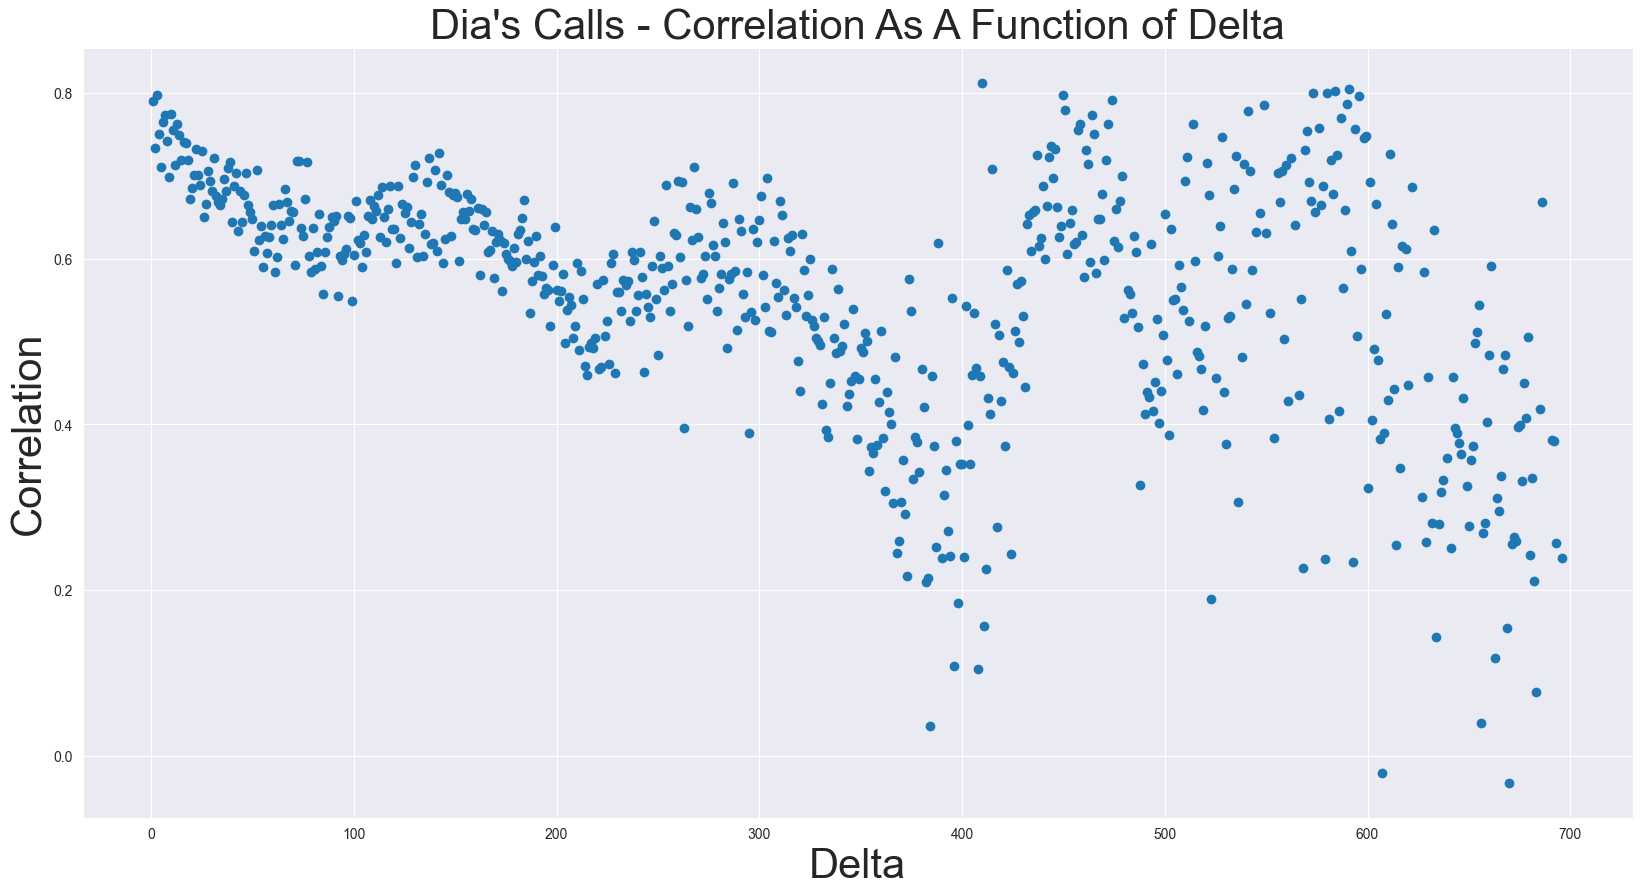

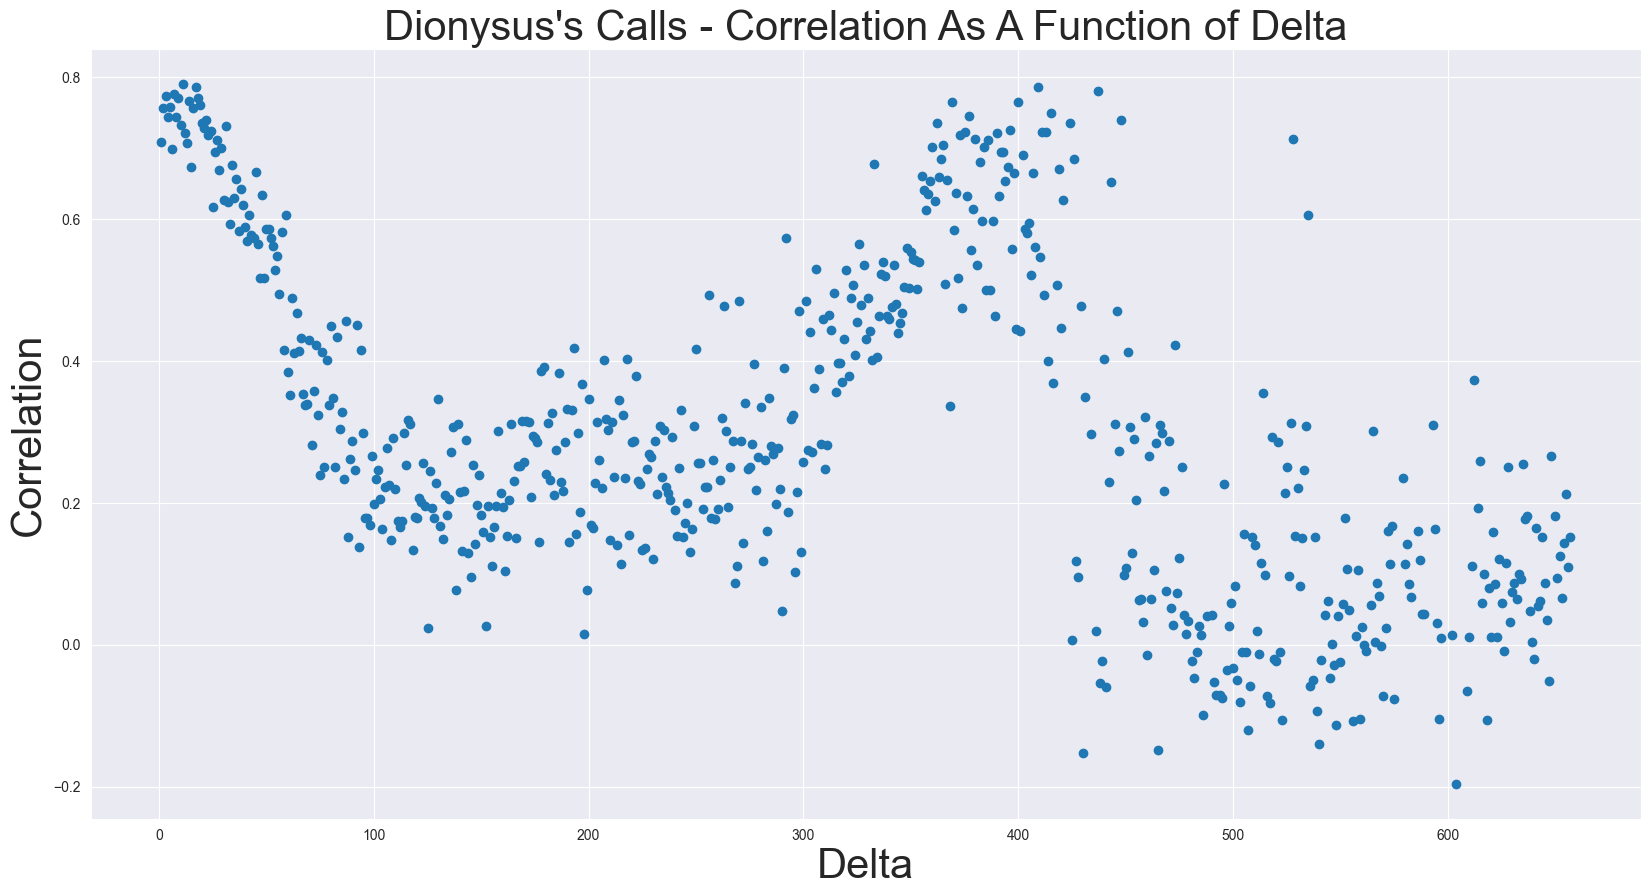

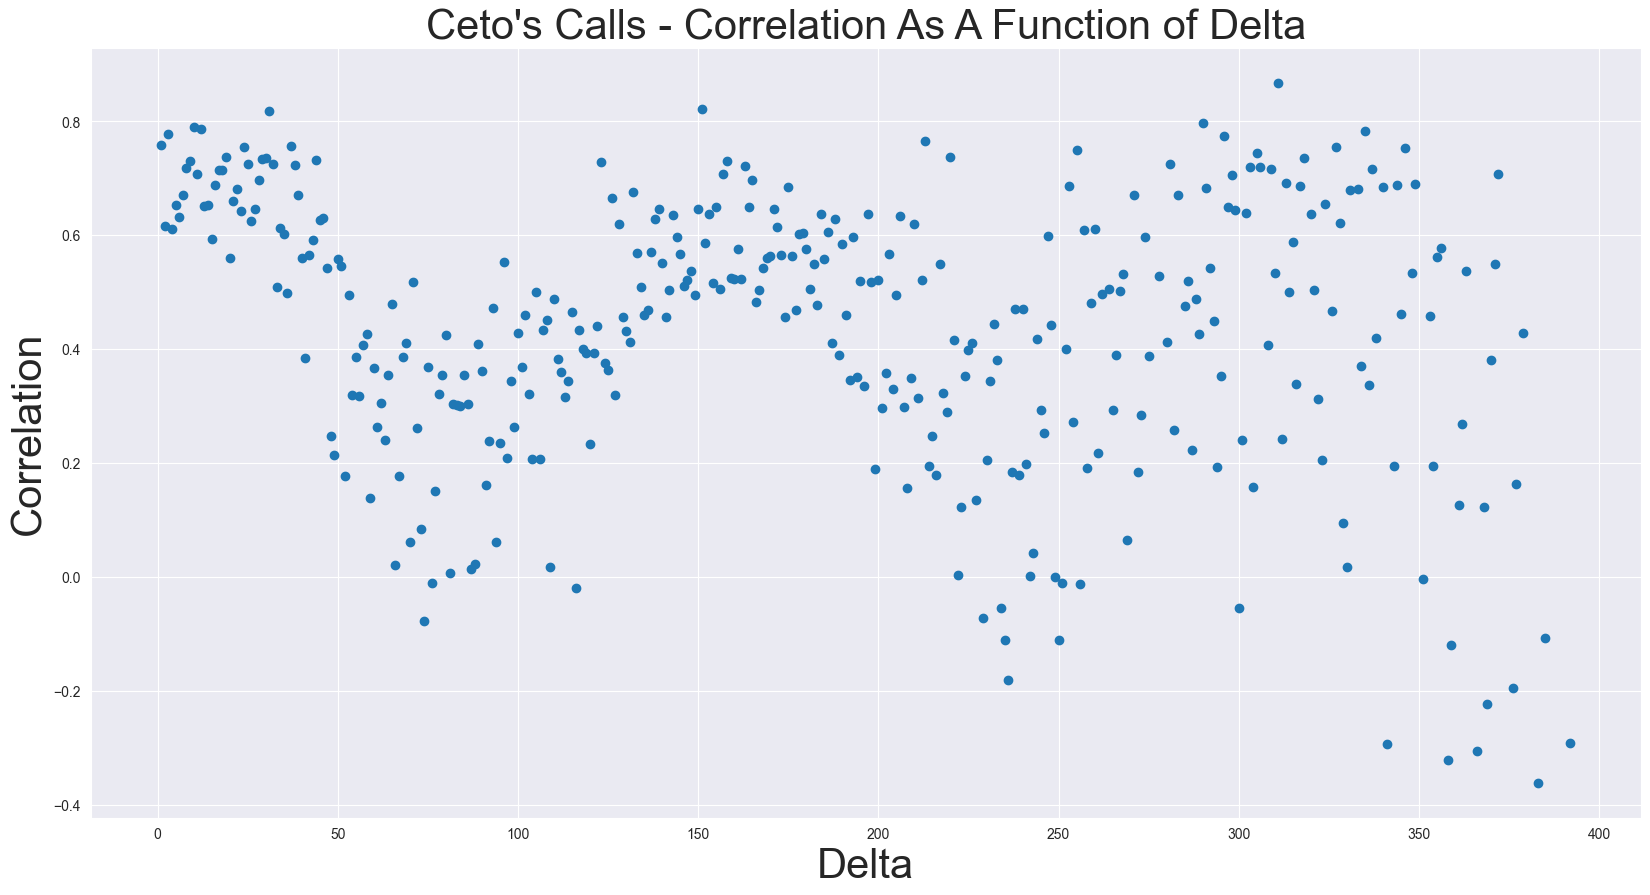

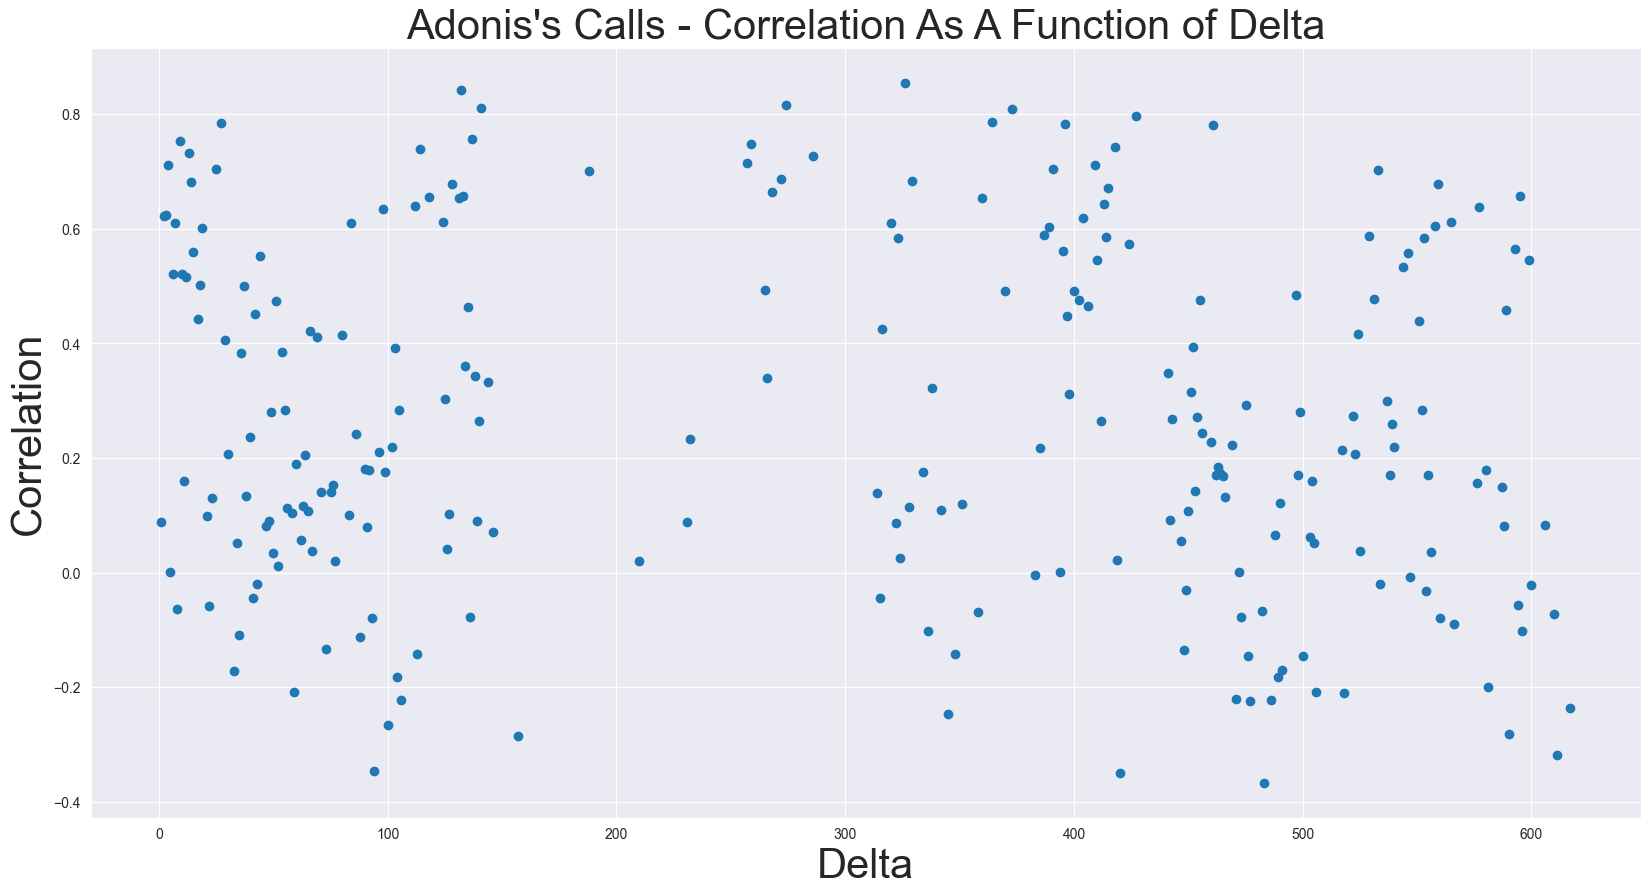

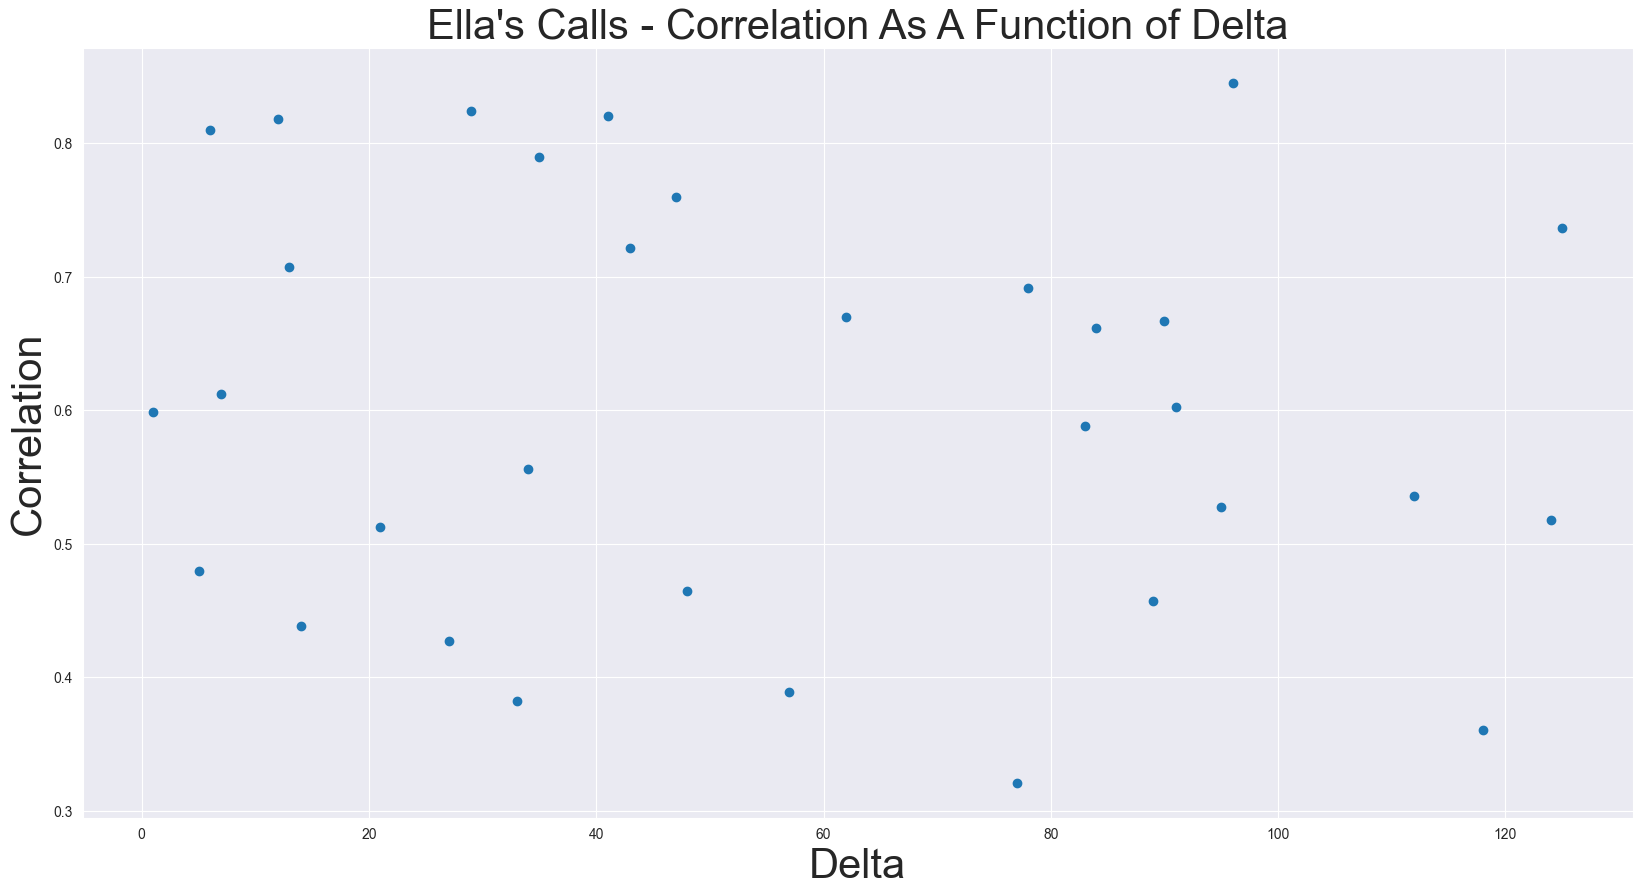

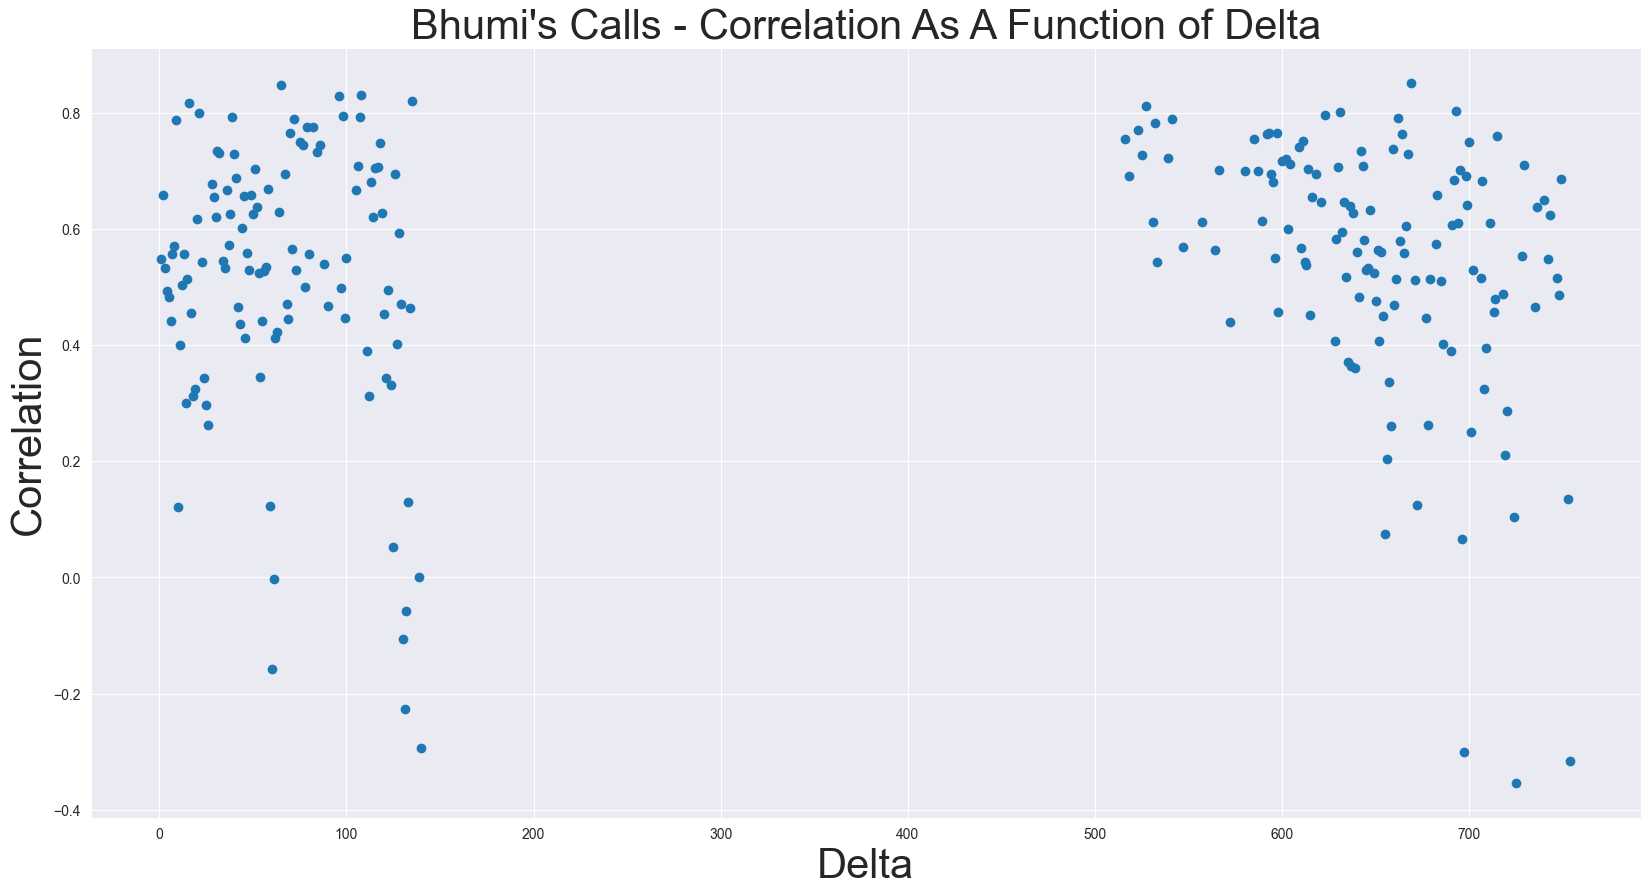

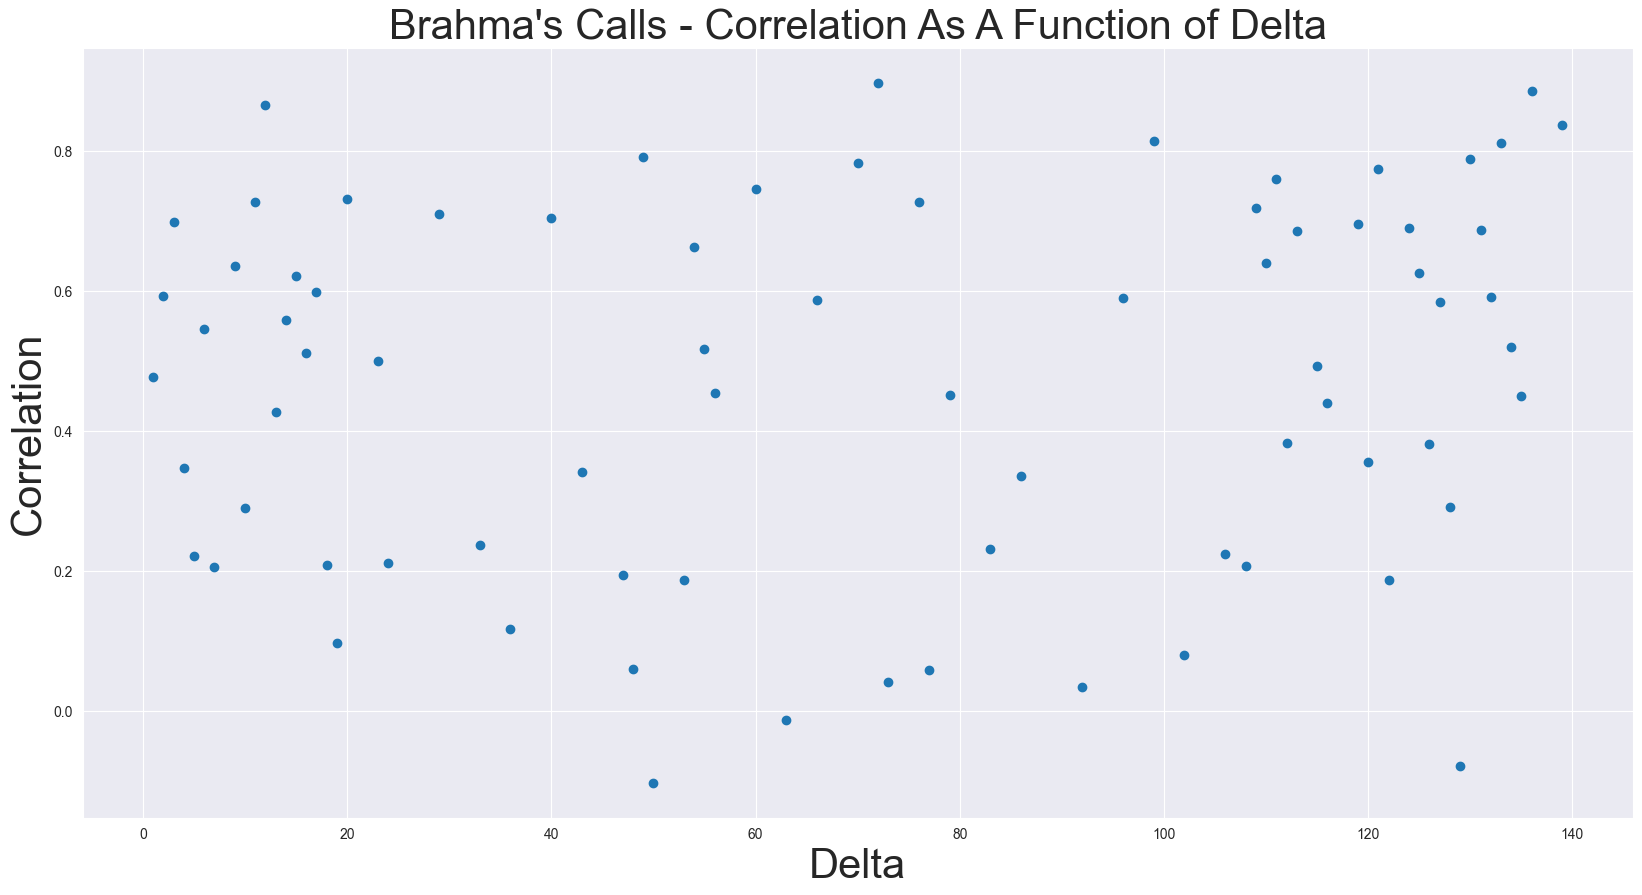

In [37]:
for caller in df["caller"].unique():
    show_average_corr_per_day_delta_for_every_caller(df,caller)

Caller: Dia
Caller: Dia - Callee: Dionysus


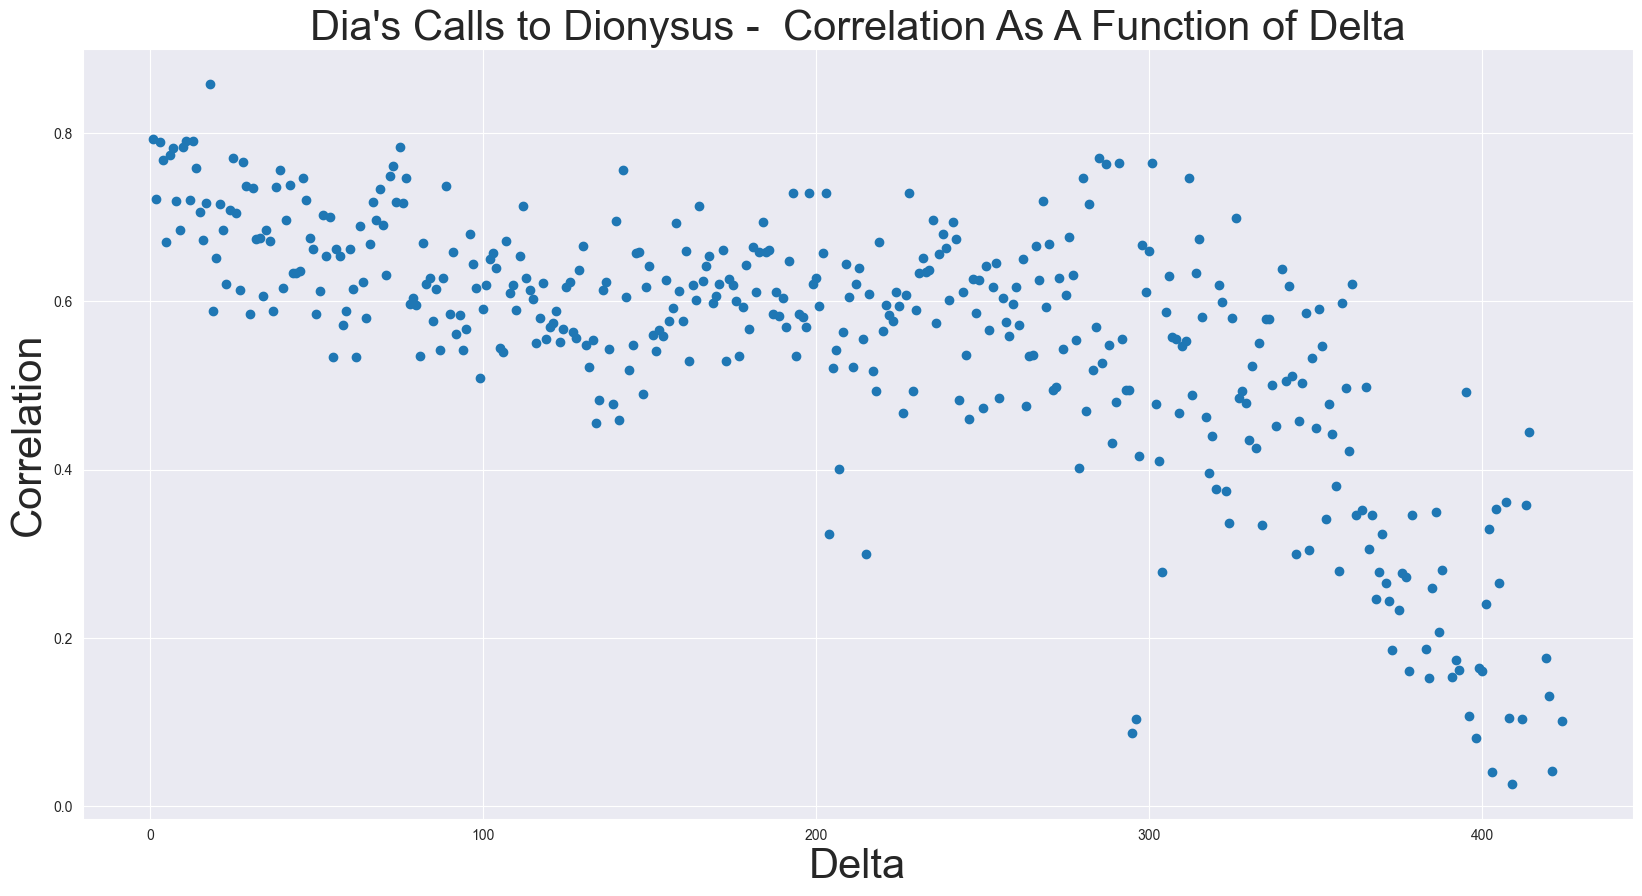

Caller: Dia - Callee: Adonis


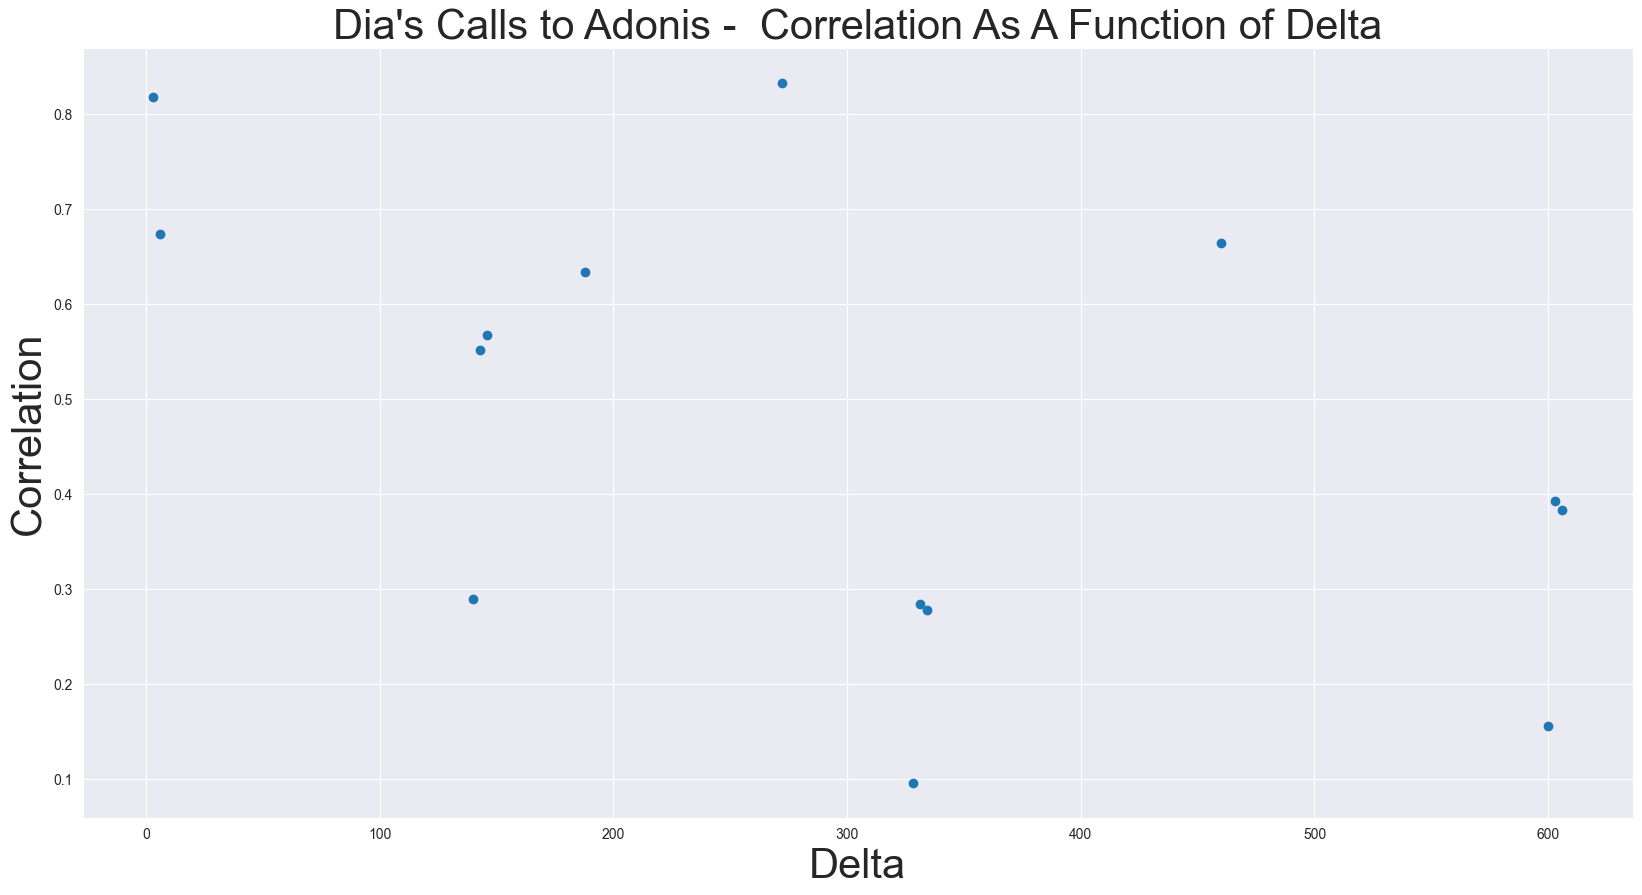

Caller: Dia - Callee: Ceto


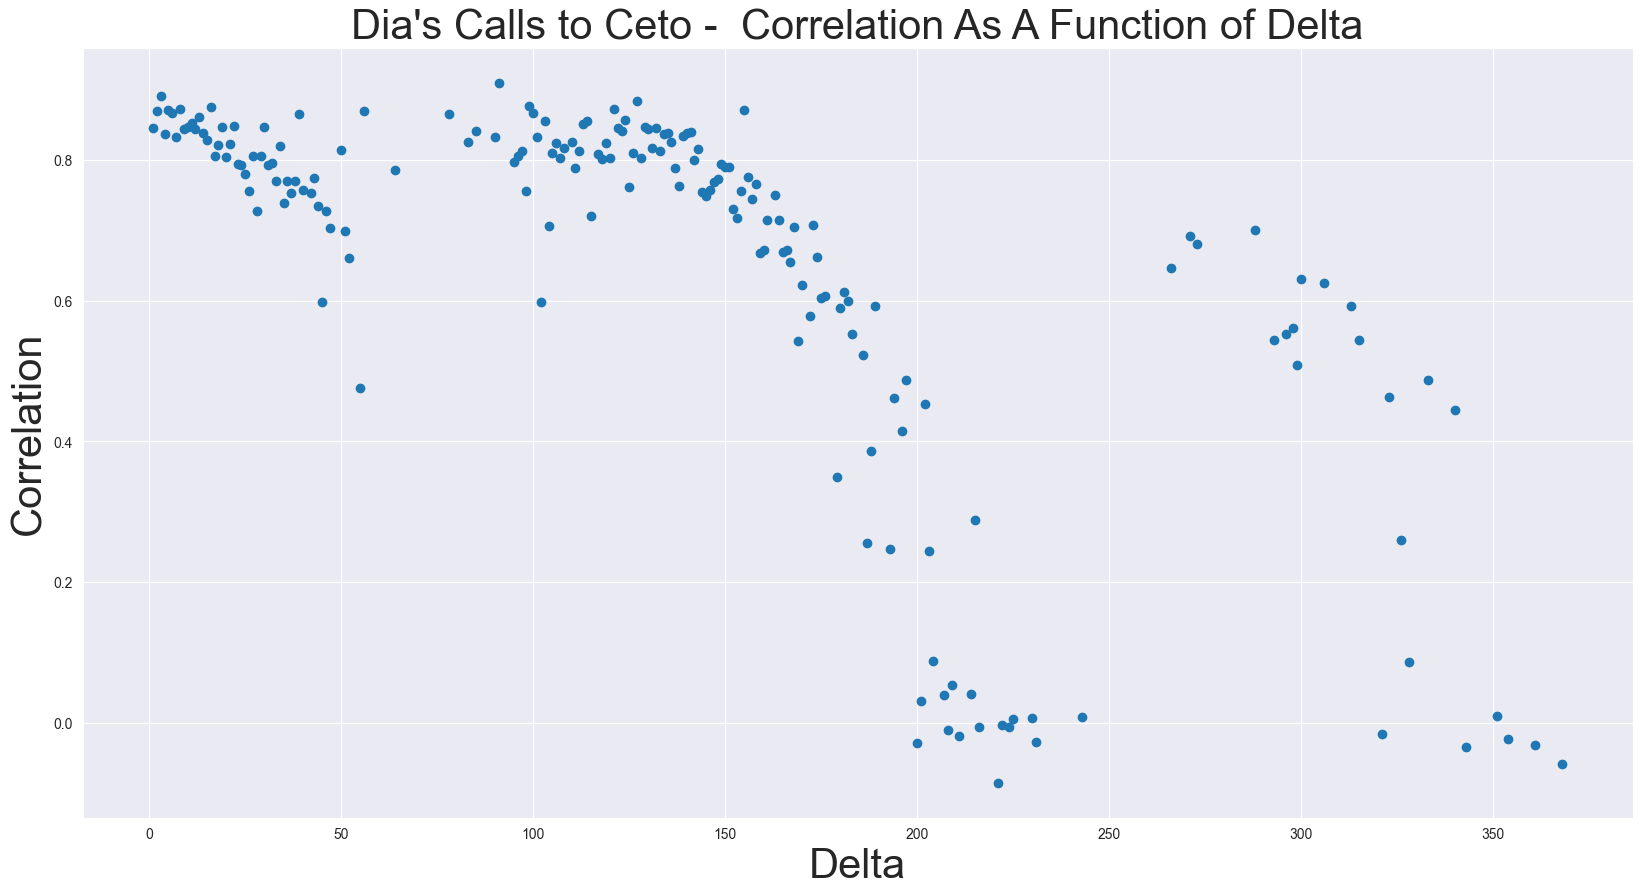

Caller: Dia - Callee: Brahma


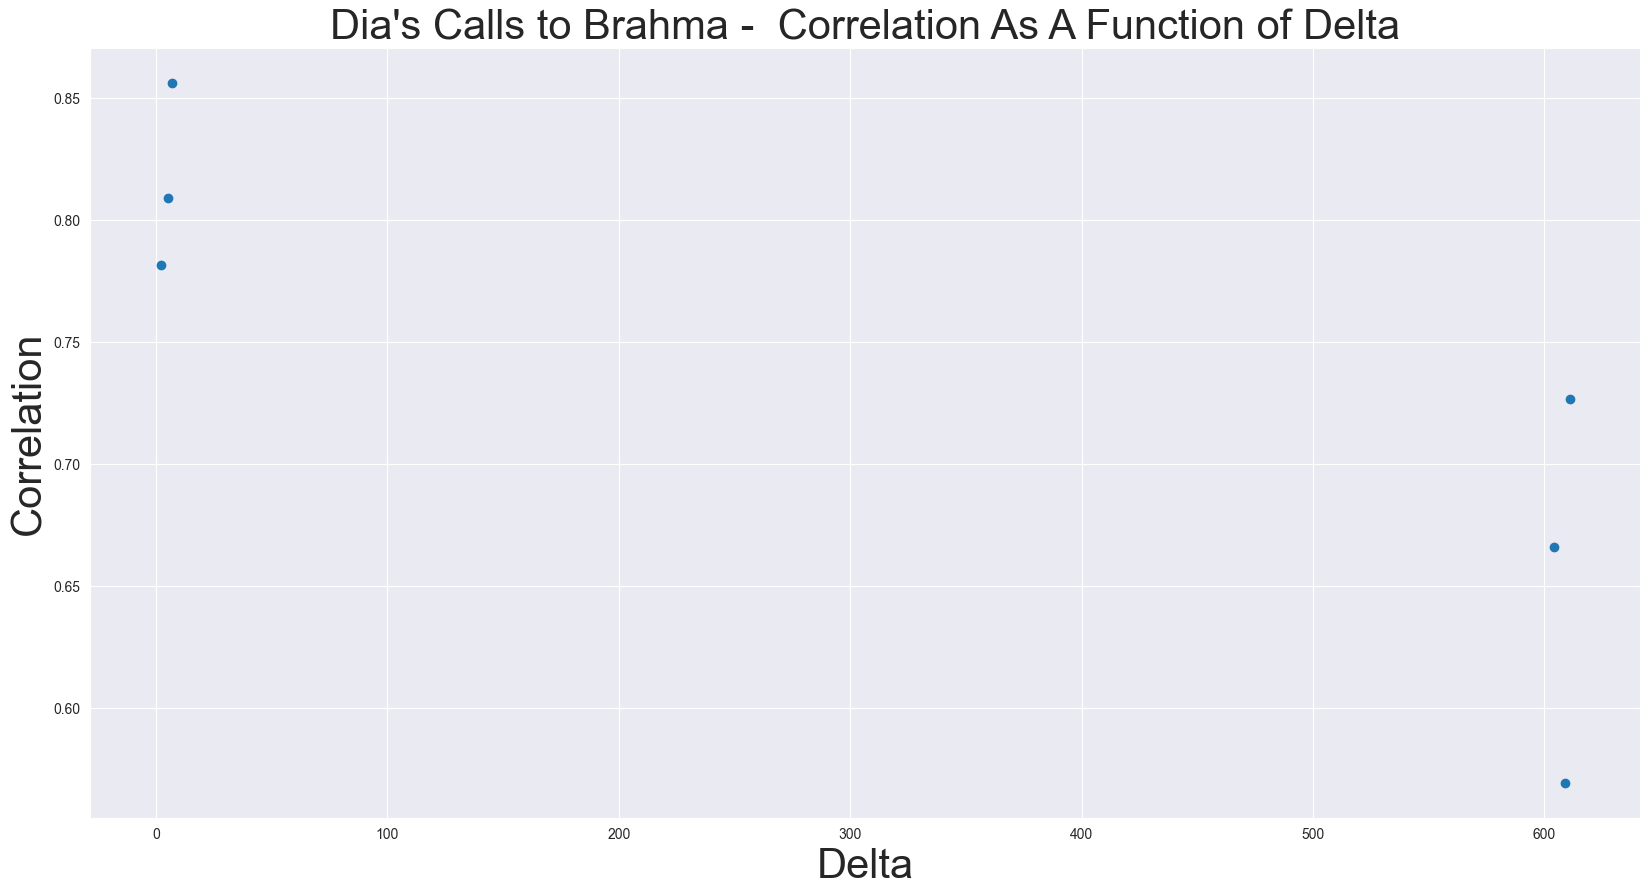

Caller: Dionysus
Caller: Dionysus - Callee: Dia


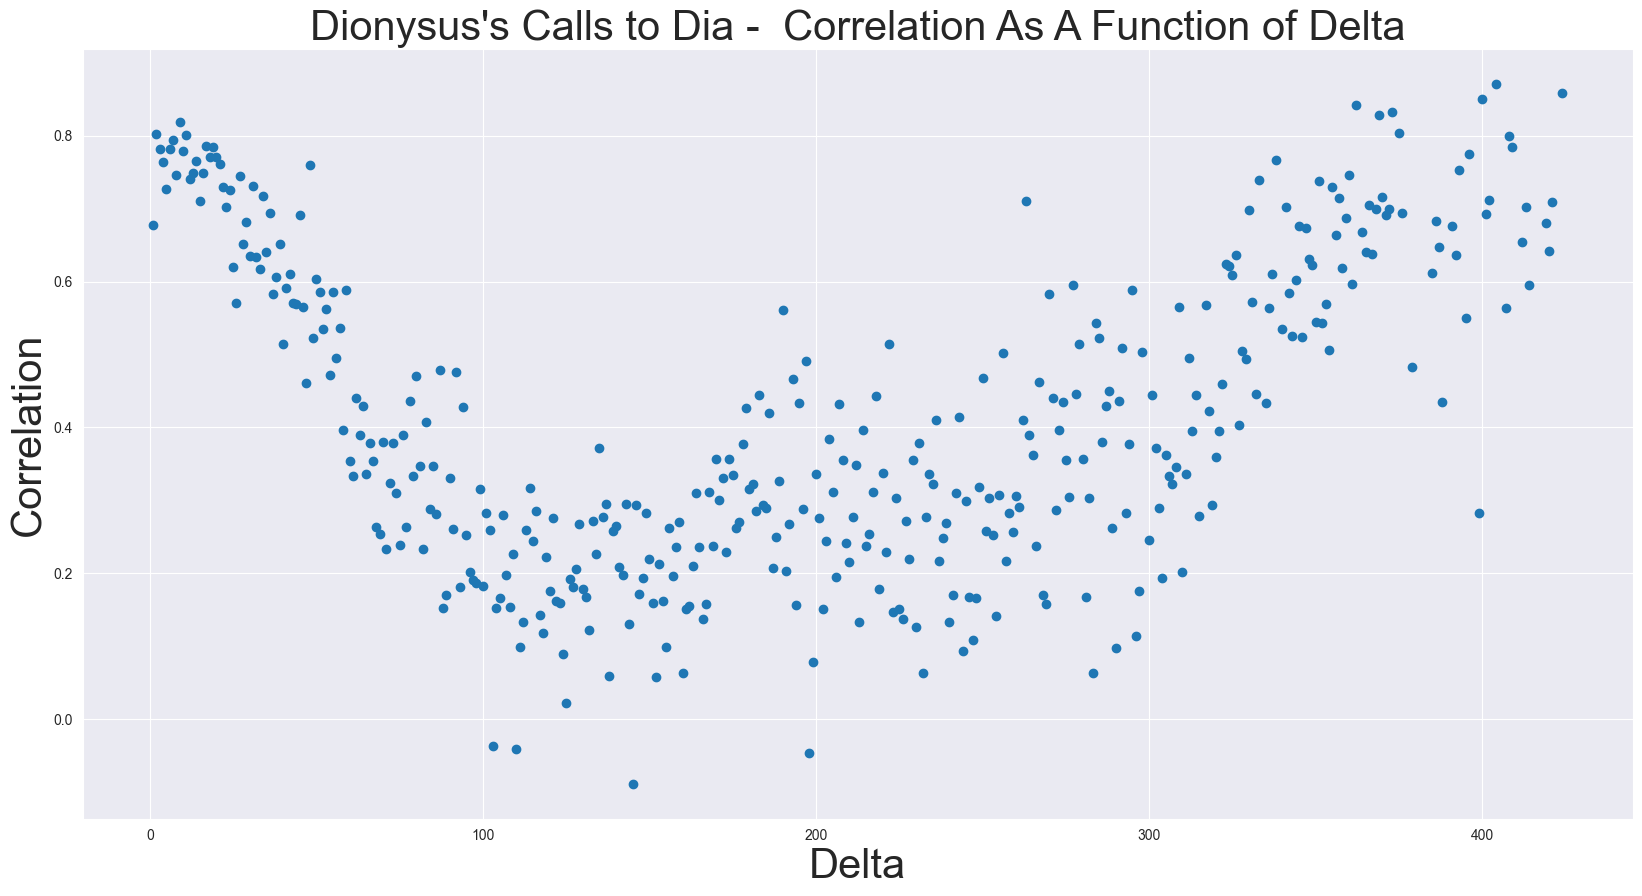

Caller: Dionysus - Callee: Ceto


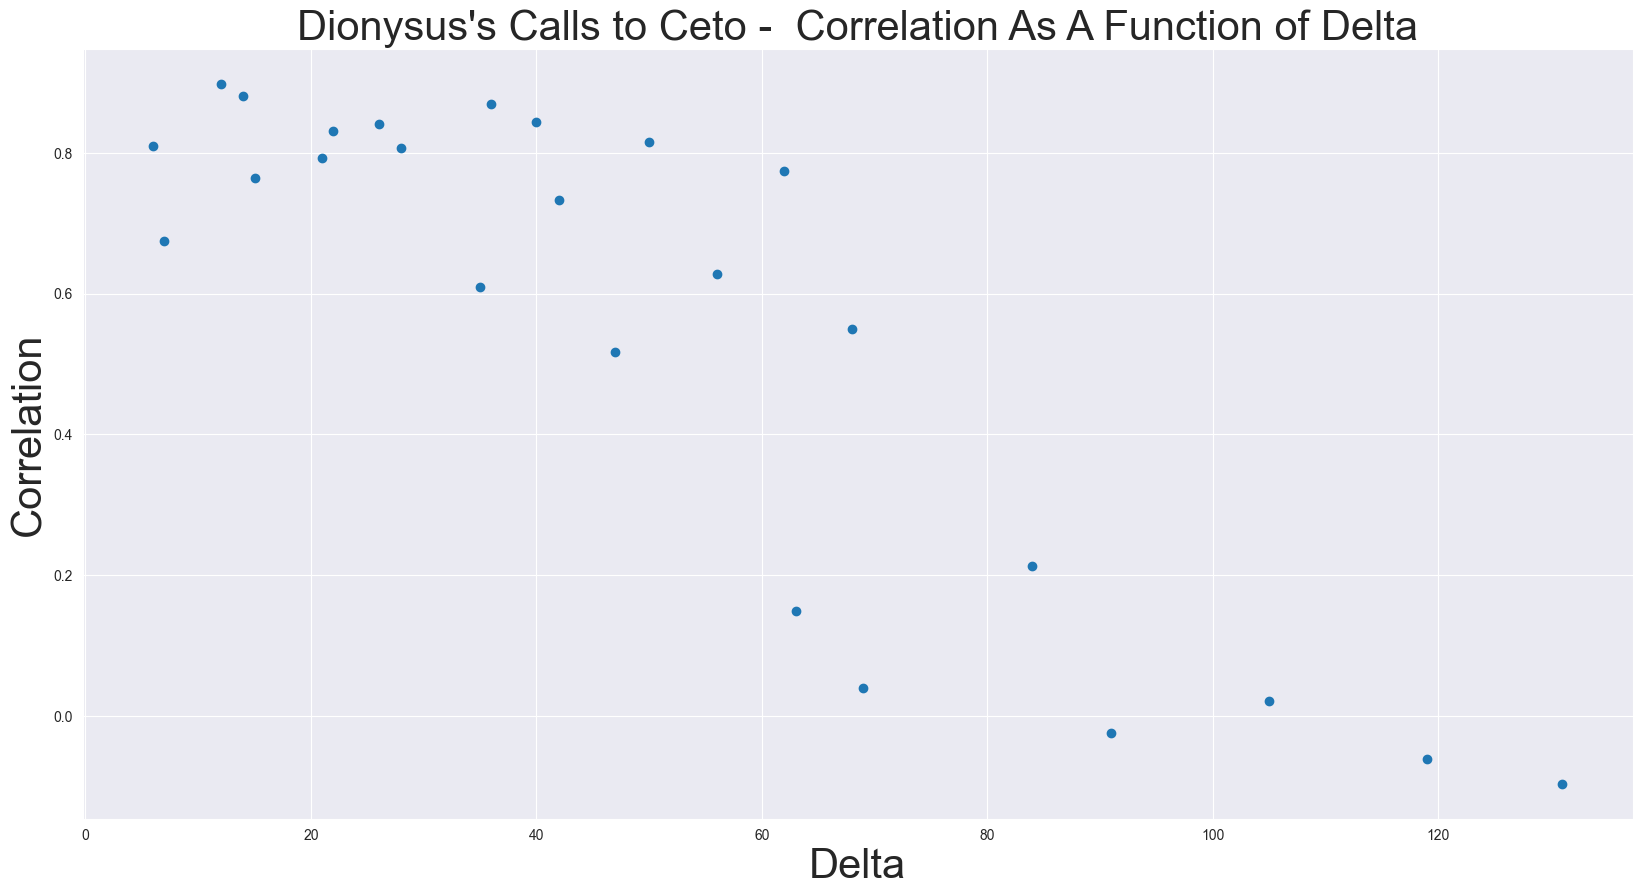

Caller: Dionysus - Callee: Bhumi


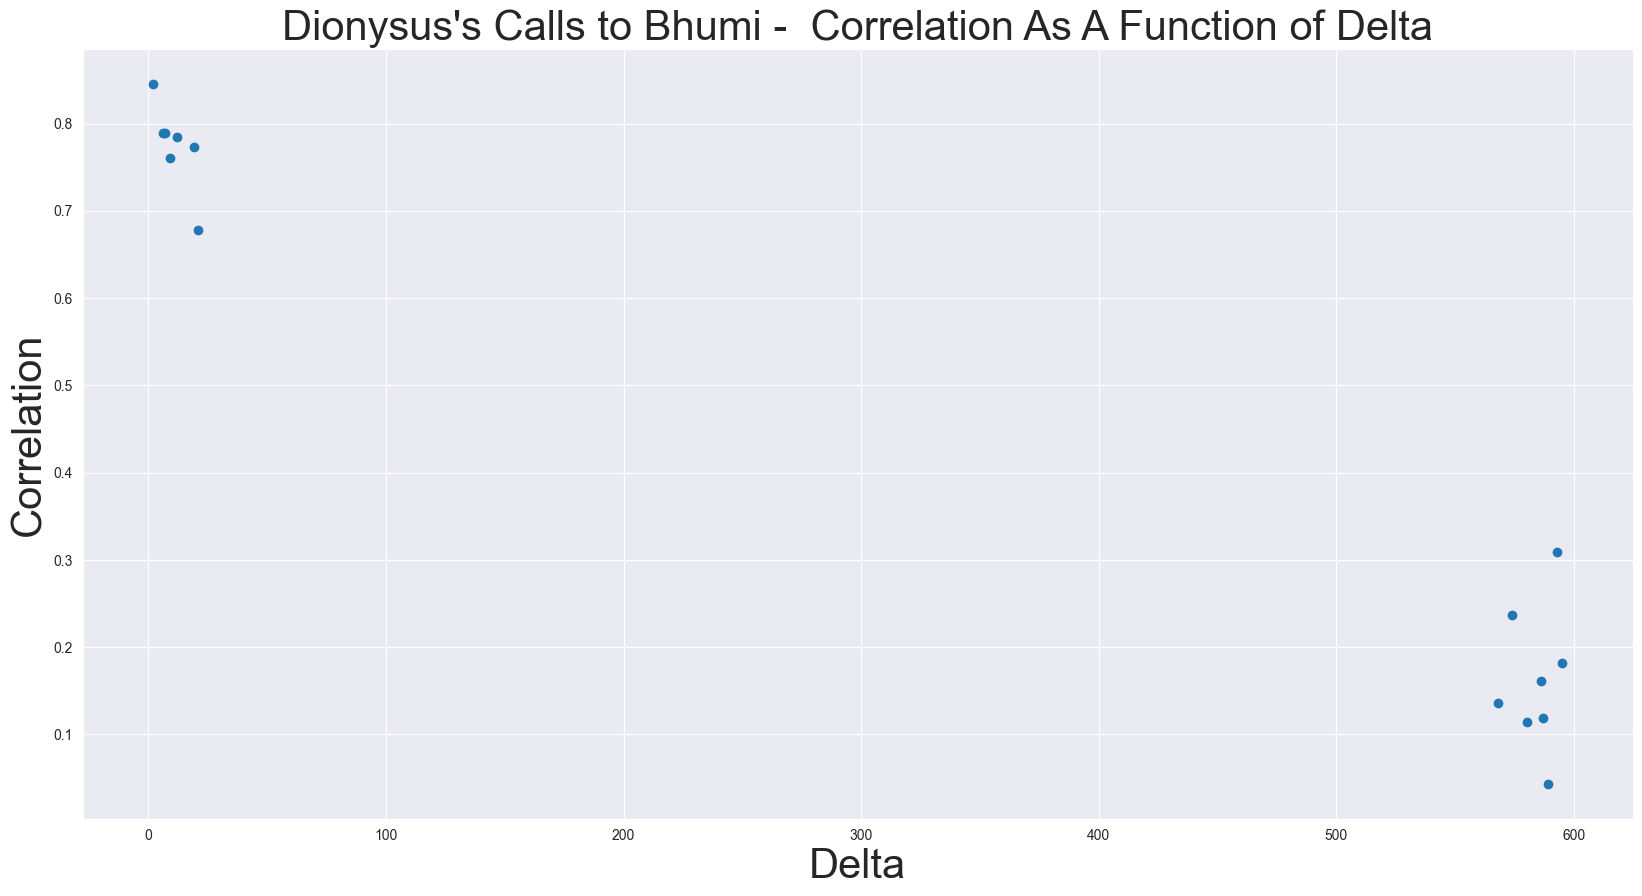

Caller: Dionysus - Callee: Adonis


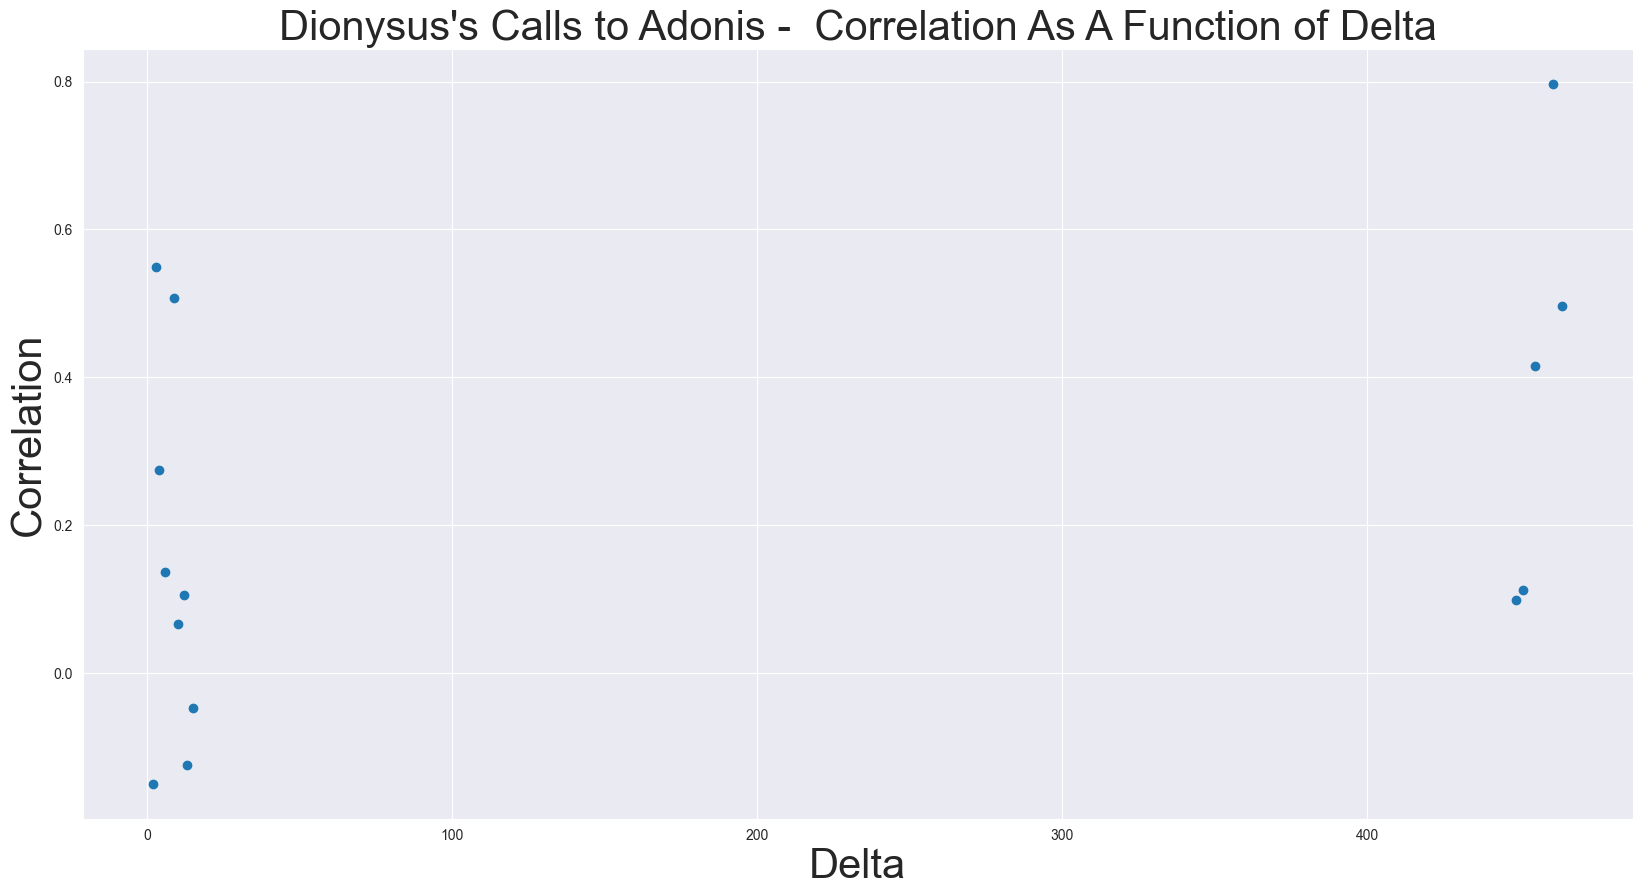

Caller: Ceto
Caller: Ceto - Callee: Dionysus


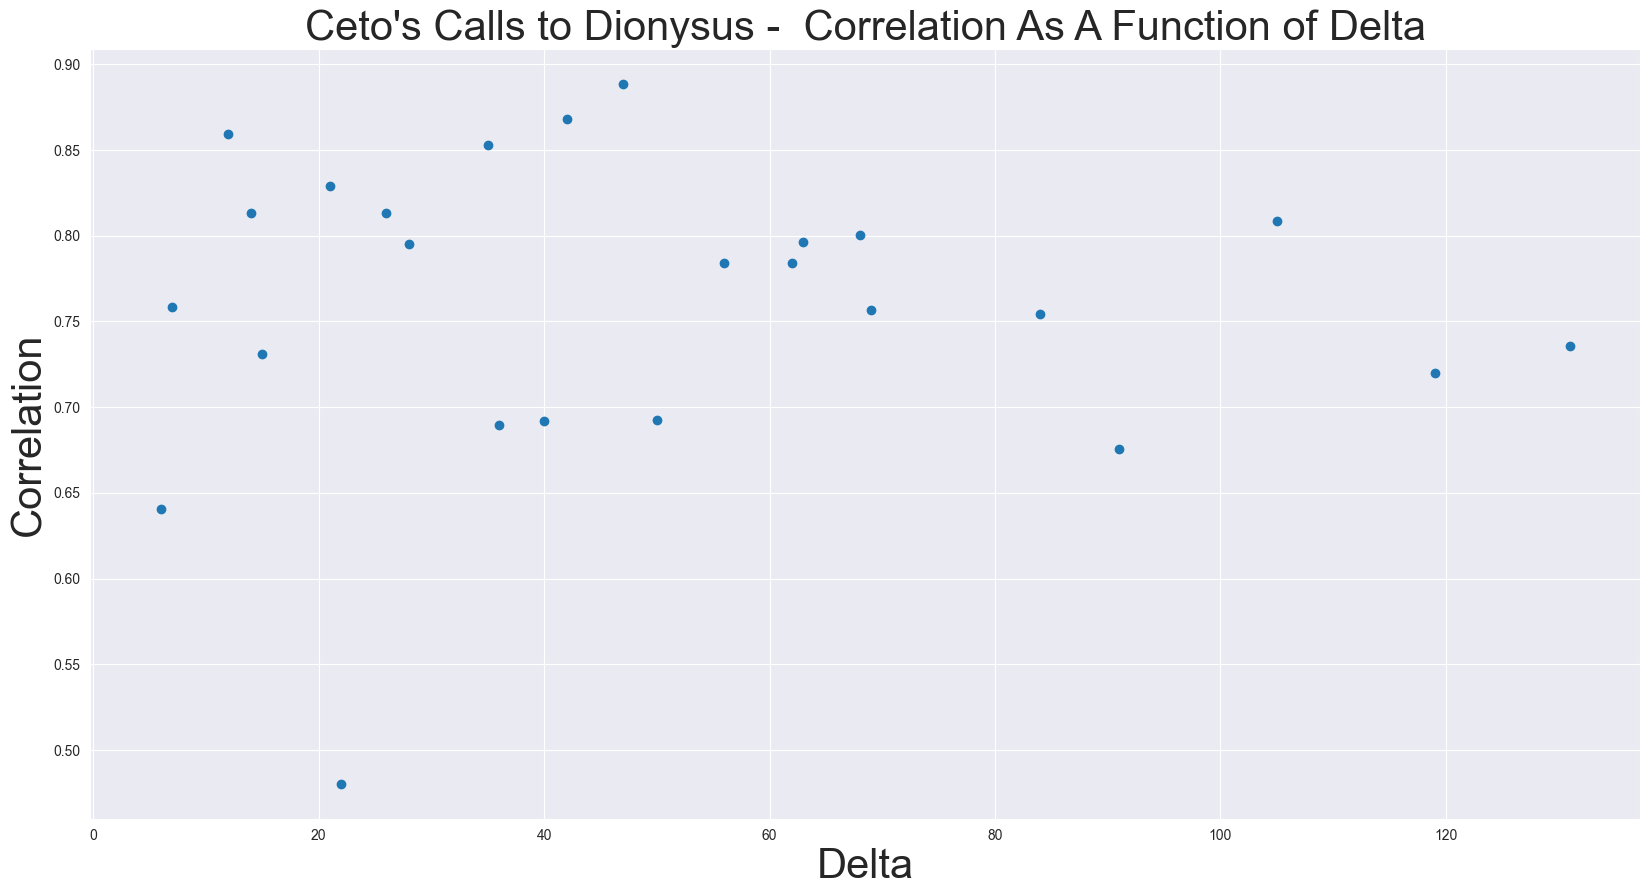

Caller: Ceto - Callee: Chaos


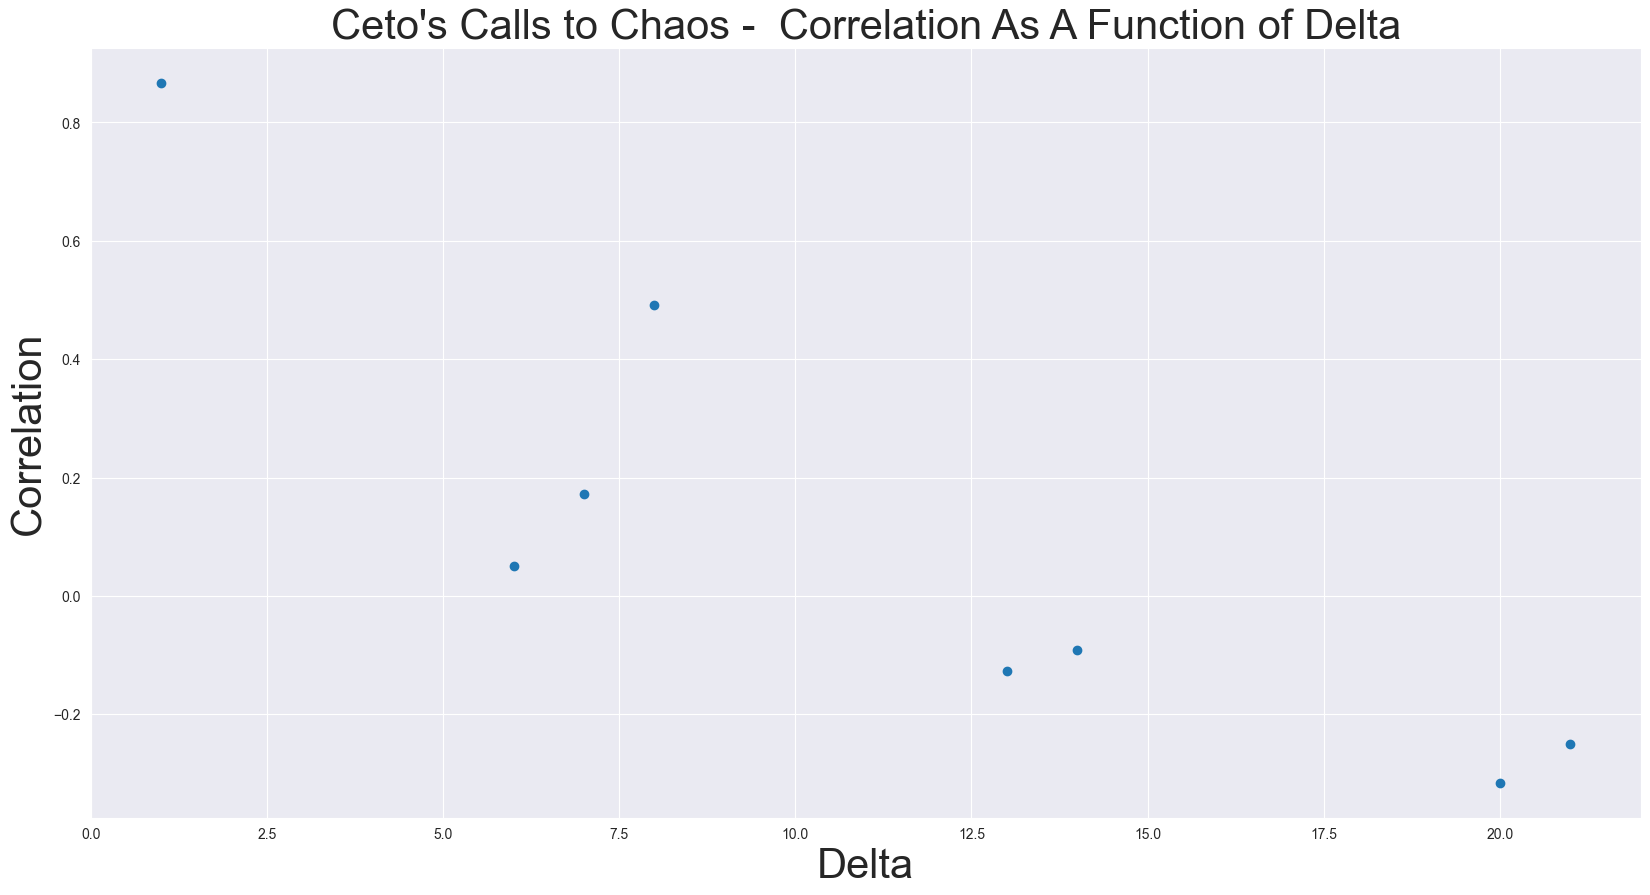

Caller: Ceto - Callee: Dia


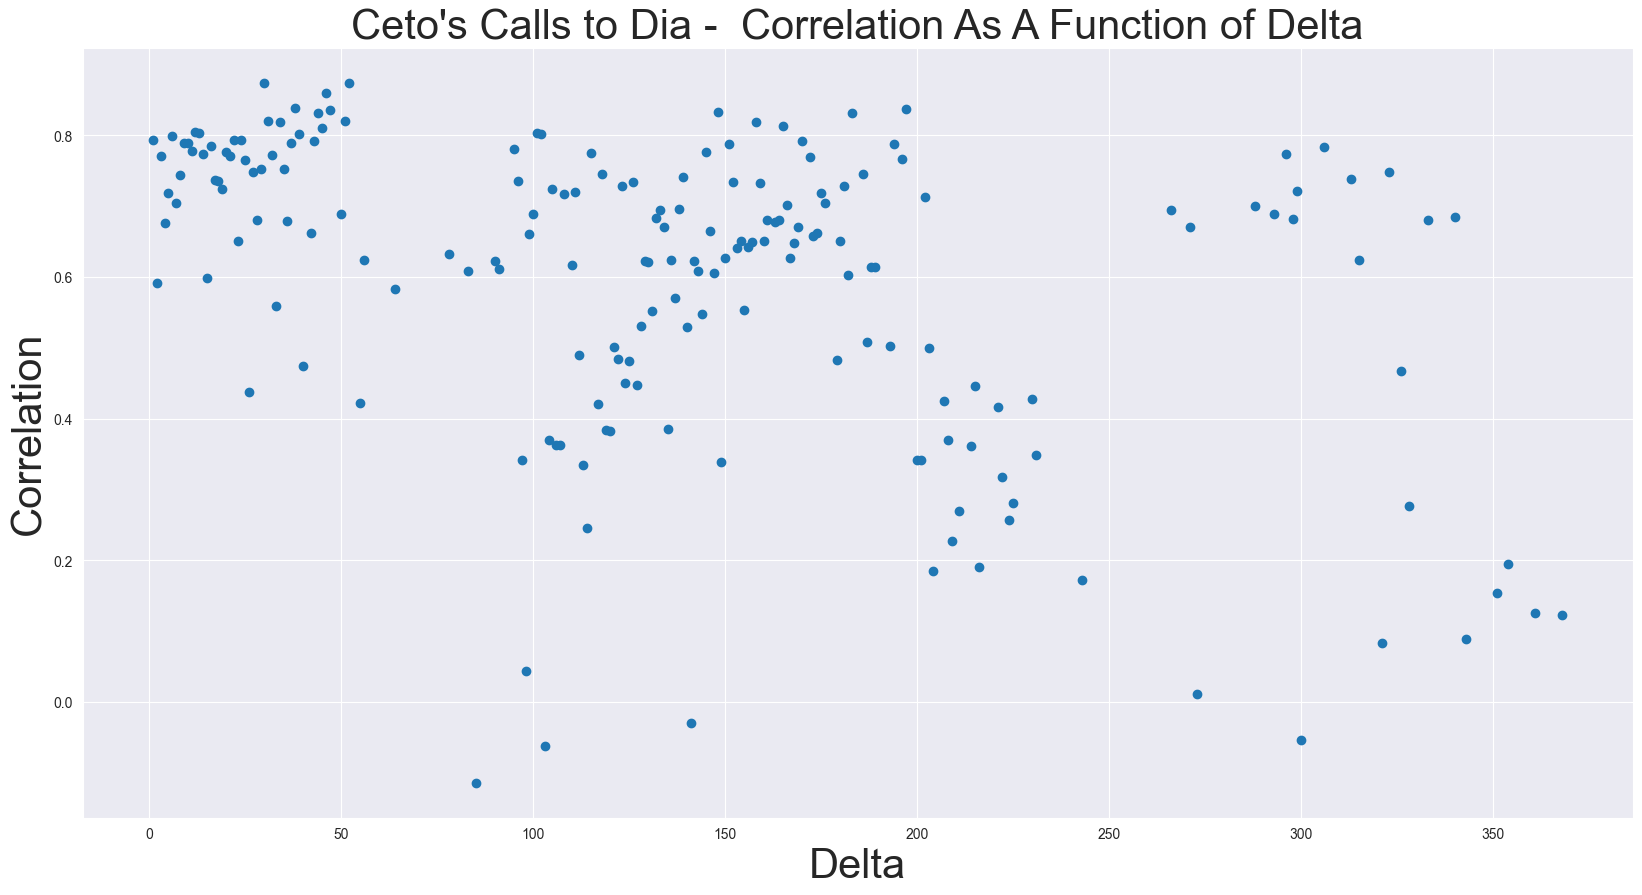

Caller: Ceto - Callee: Adonis


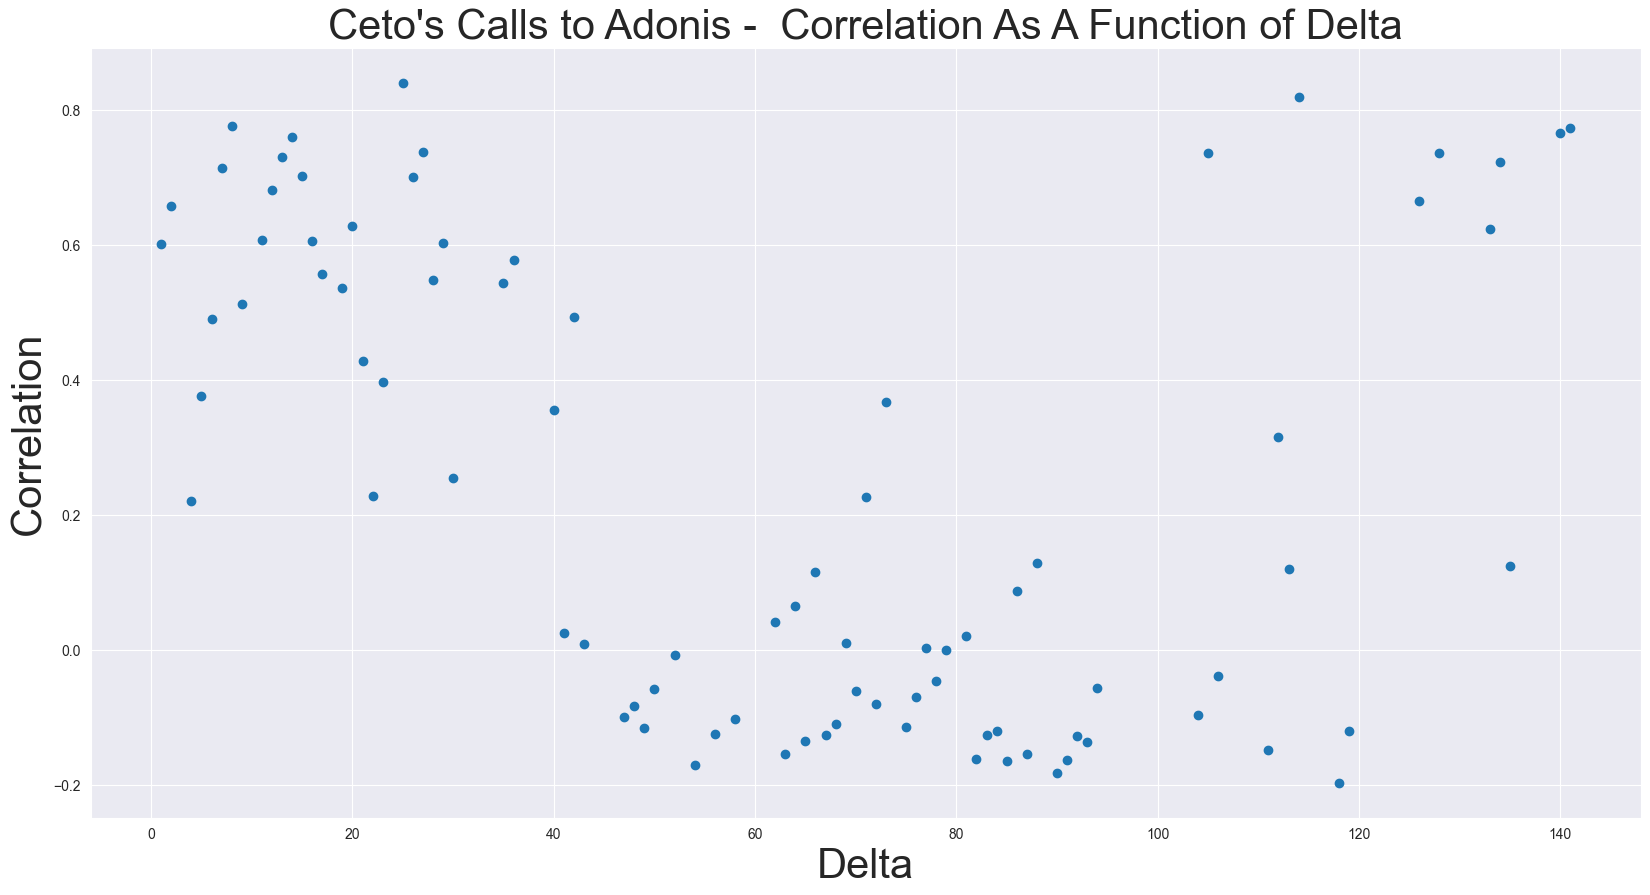

Caller: Adonis
Caller: Adonis - Callee: Dia


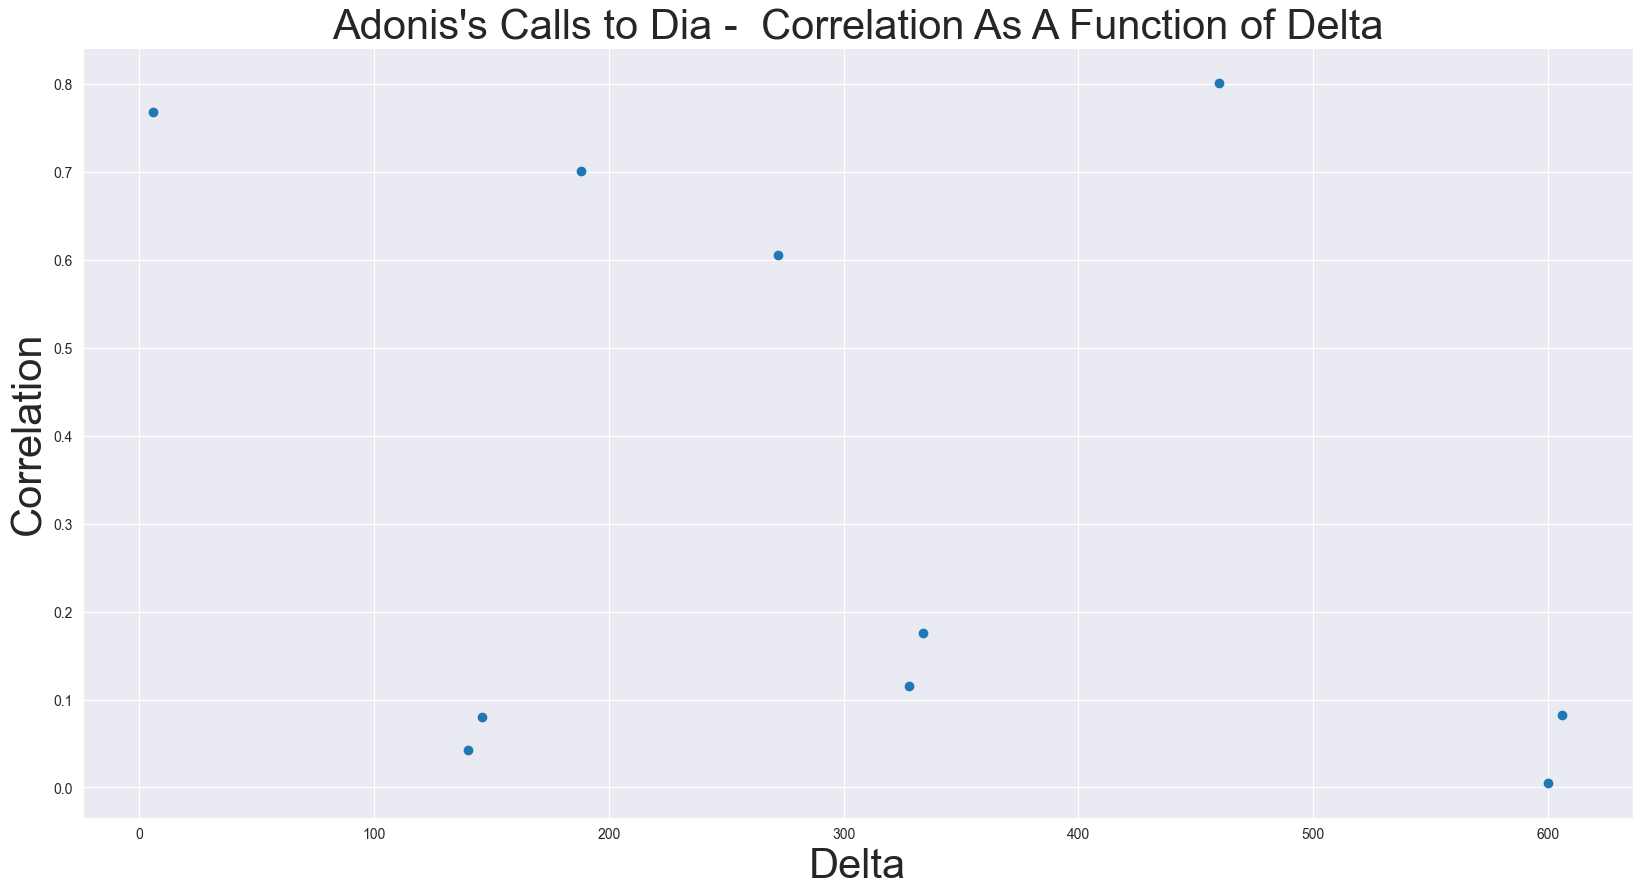

Caller: Adonis - Callee: Ceto


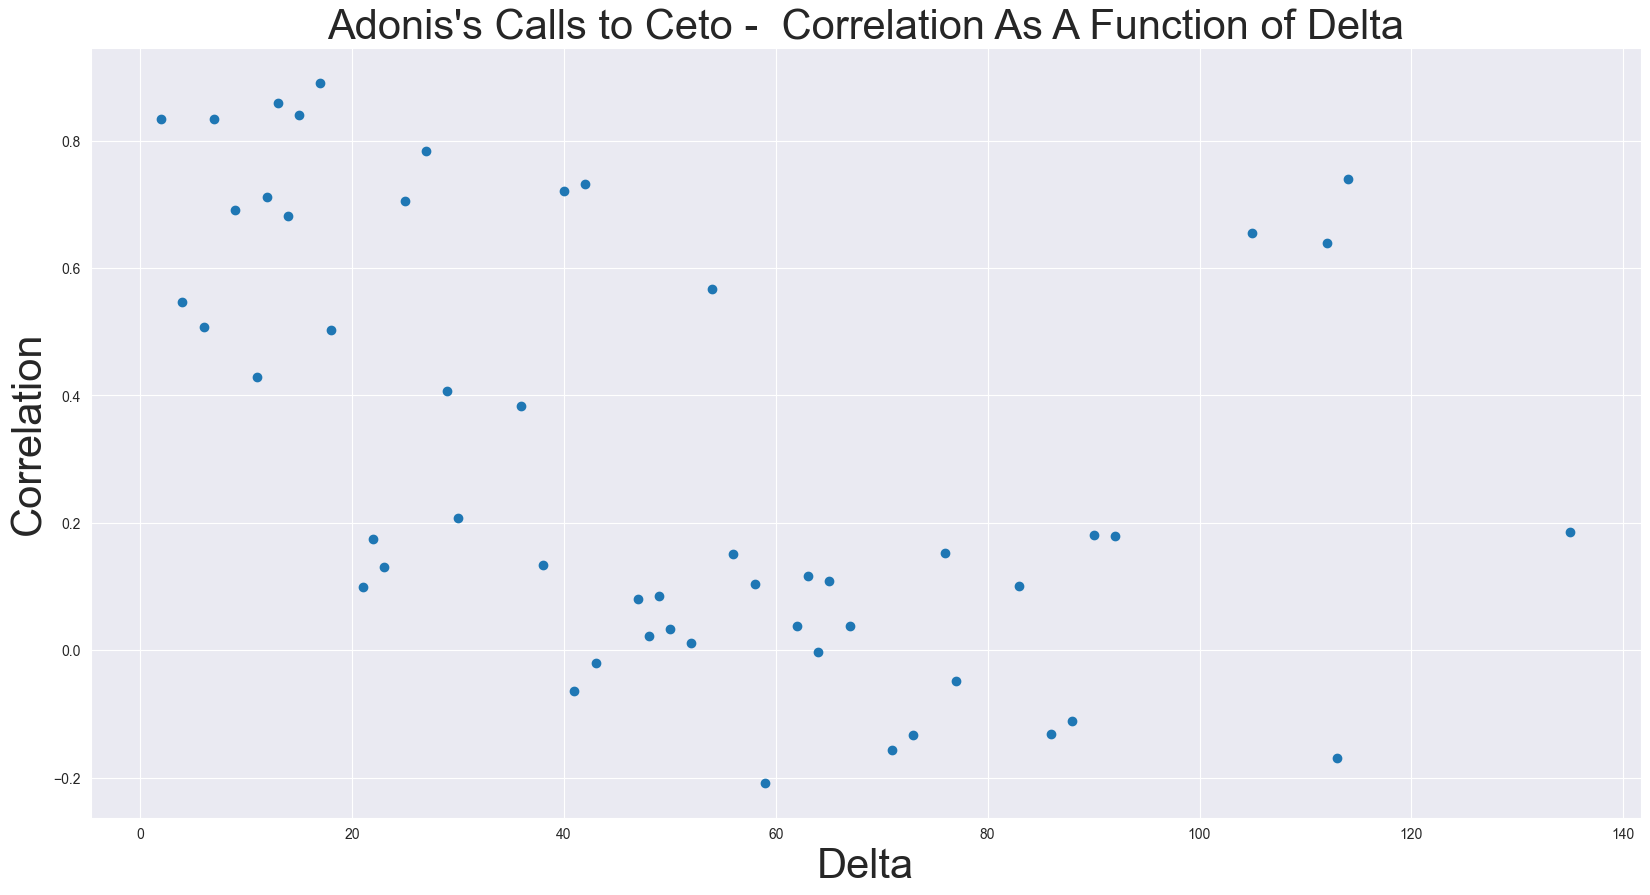

Caller: Adonis - Callee: Dionysus


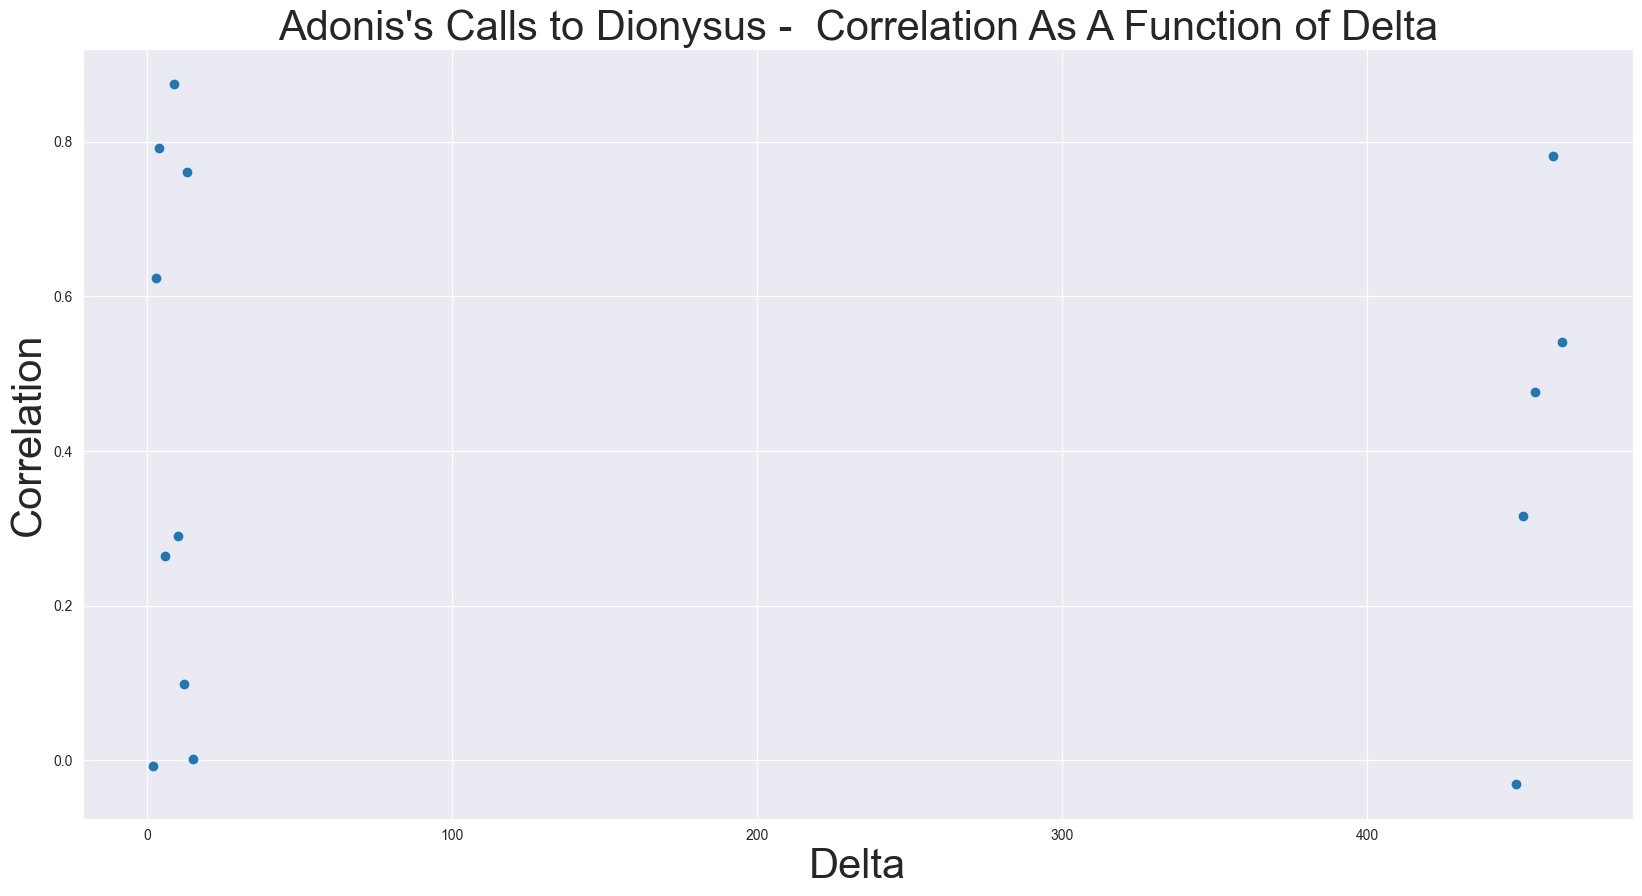

Caller: Ella
Caller: Bhumi
Caller: Bhumi - Callee: Brahma


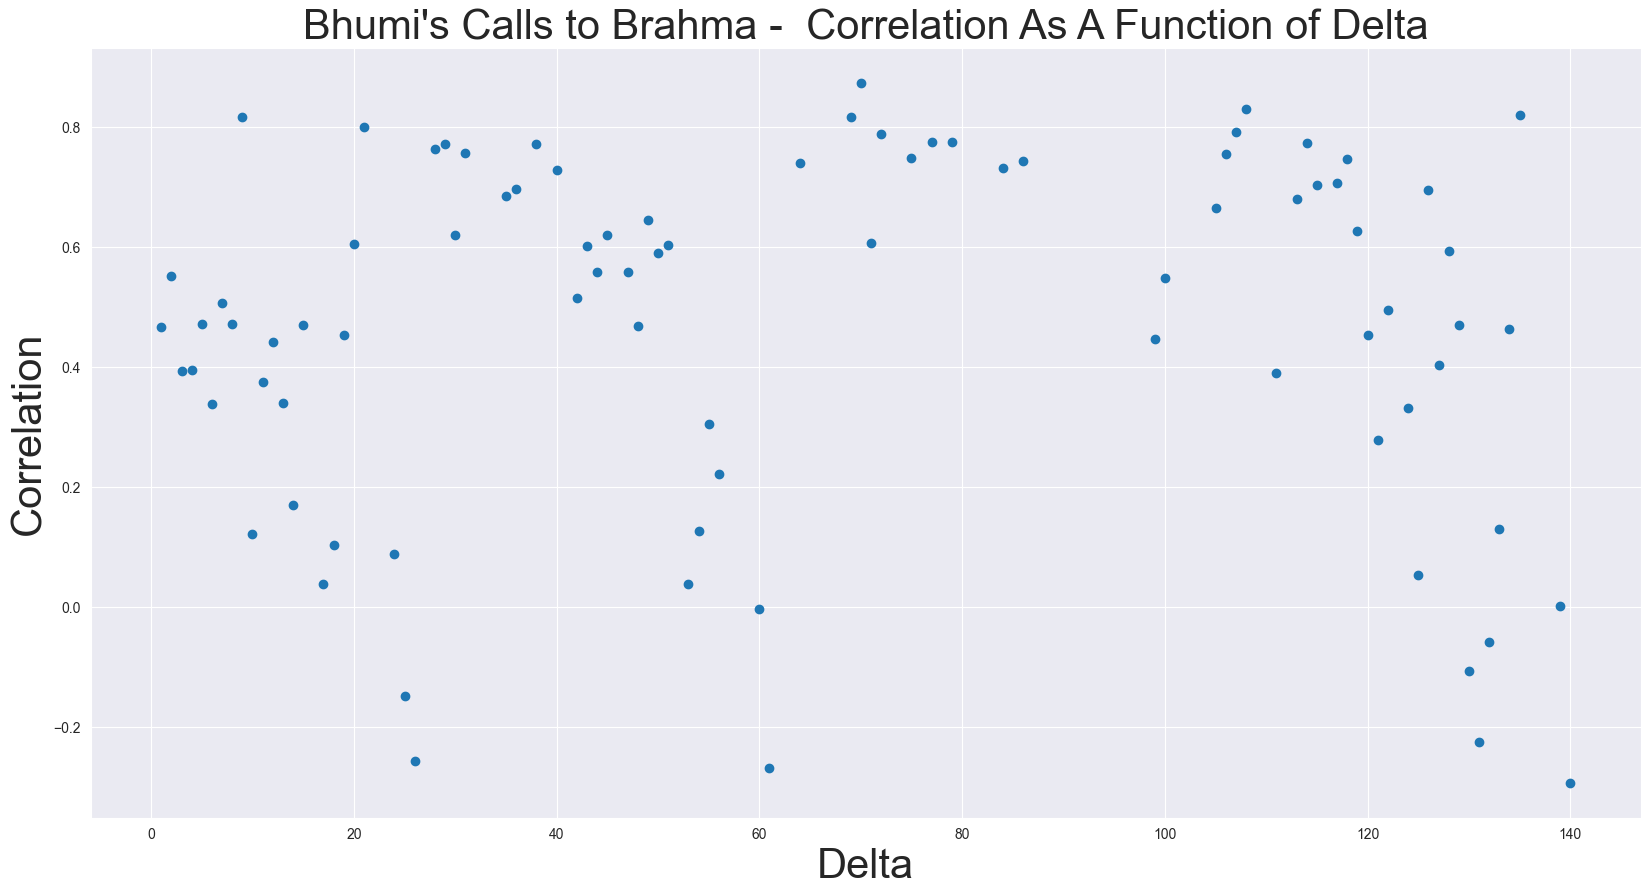

Caller: Brahma
Caller: Brahma - Callee: Bhumi


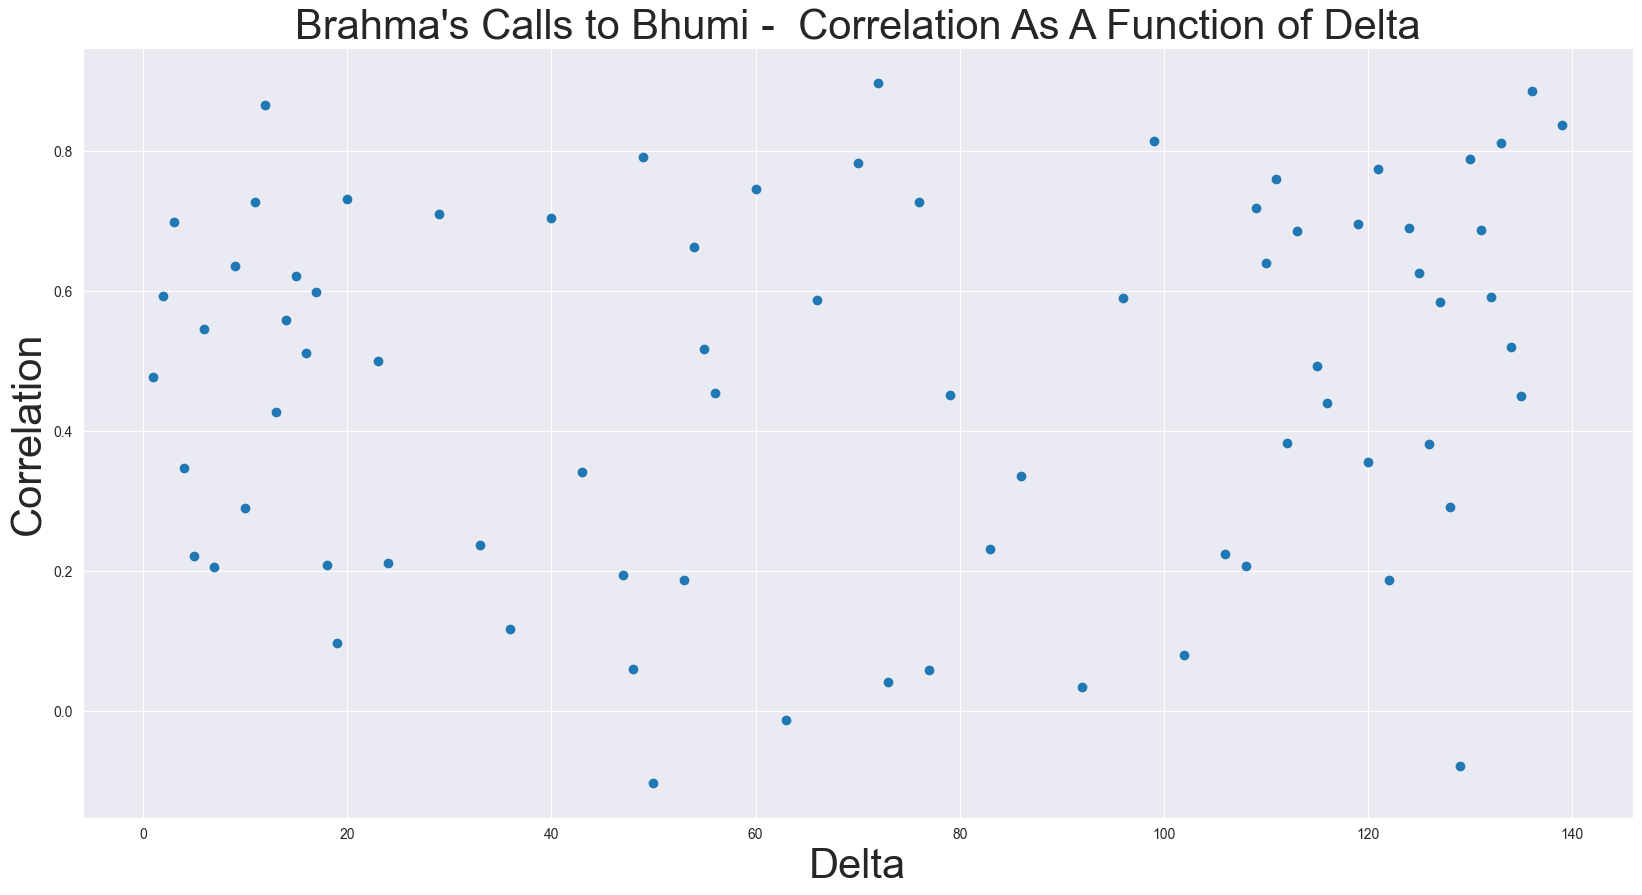

In [38]:
for caller in df["caller"].unique():
    show_average_corr_per_day_delta_for_every_monkey_pair(df,caller)

In [39]:
def show_average_corr_per_day_delta_for_every_caller_2(df,caller):
    df_caller = df[df['caller'] == caller]
    sessions_avg_spect = get_average_spect_per_session(df_caller)
    sessions_corr_per_day_delta = get_sessions_corr_per_delta(sessions_avg_spect)
    corr_mean_per_day_delta = get_corr_mean_per_delta(sessions_corr_per_day_delta)
    plot_delta_to_corr(corr_mean_per_day_delta.keys(),corr_mean_per_day_delta.values(),caller)
    return corr_mean_per_day_delta

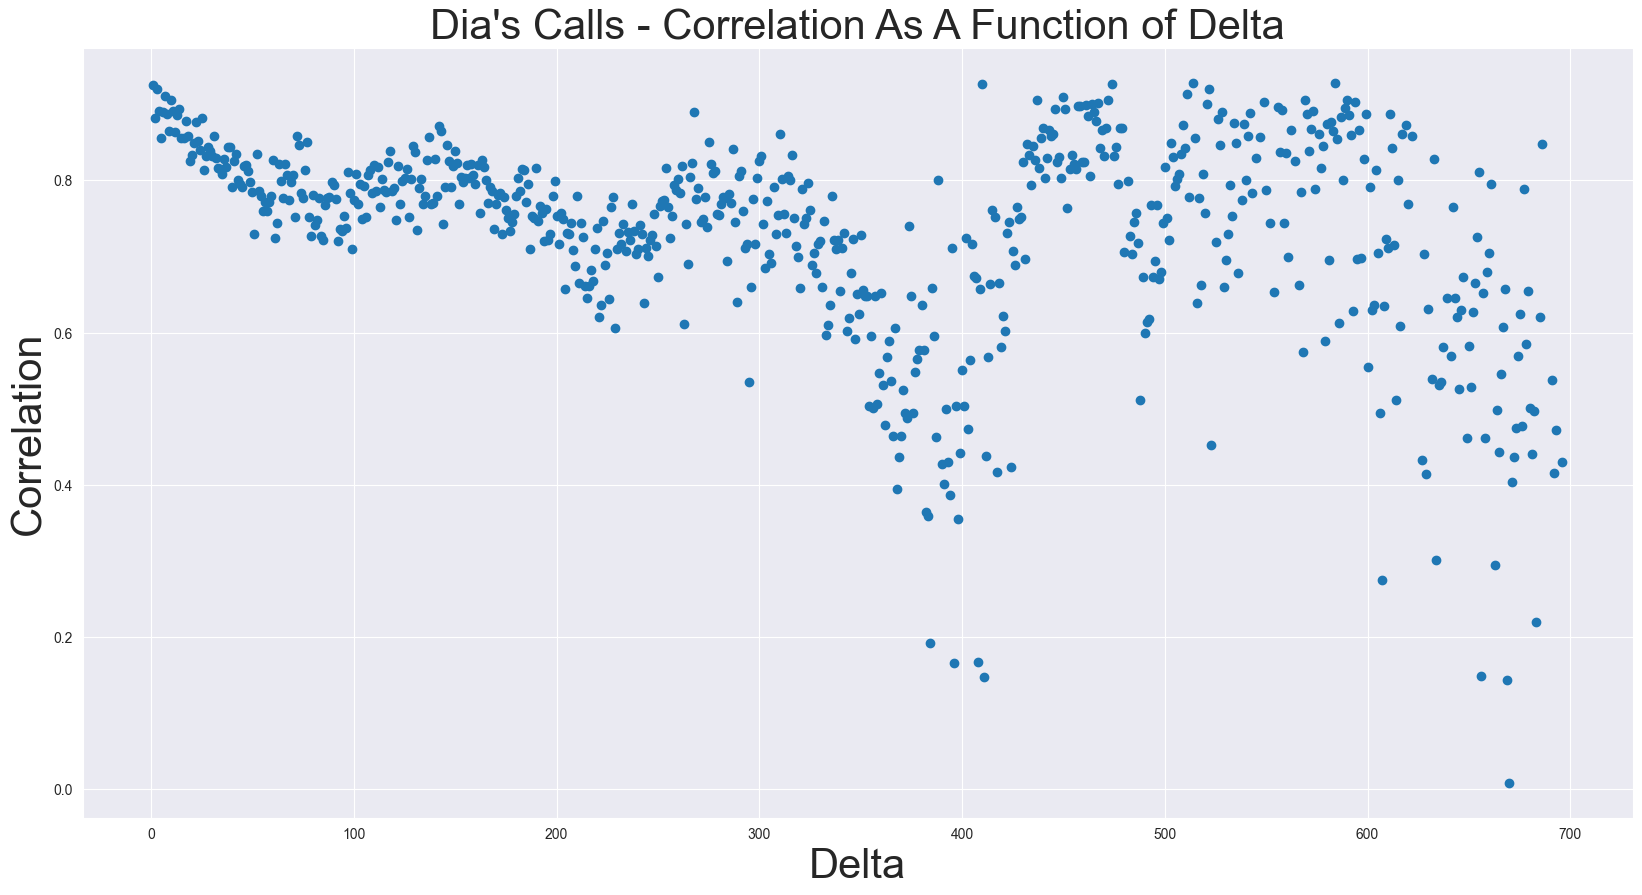

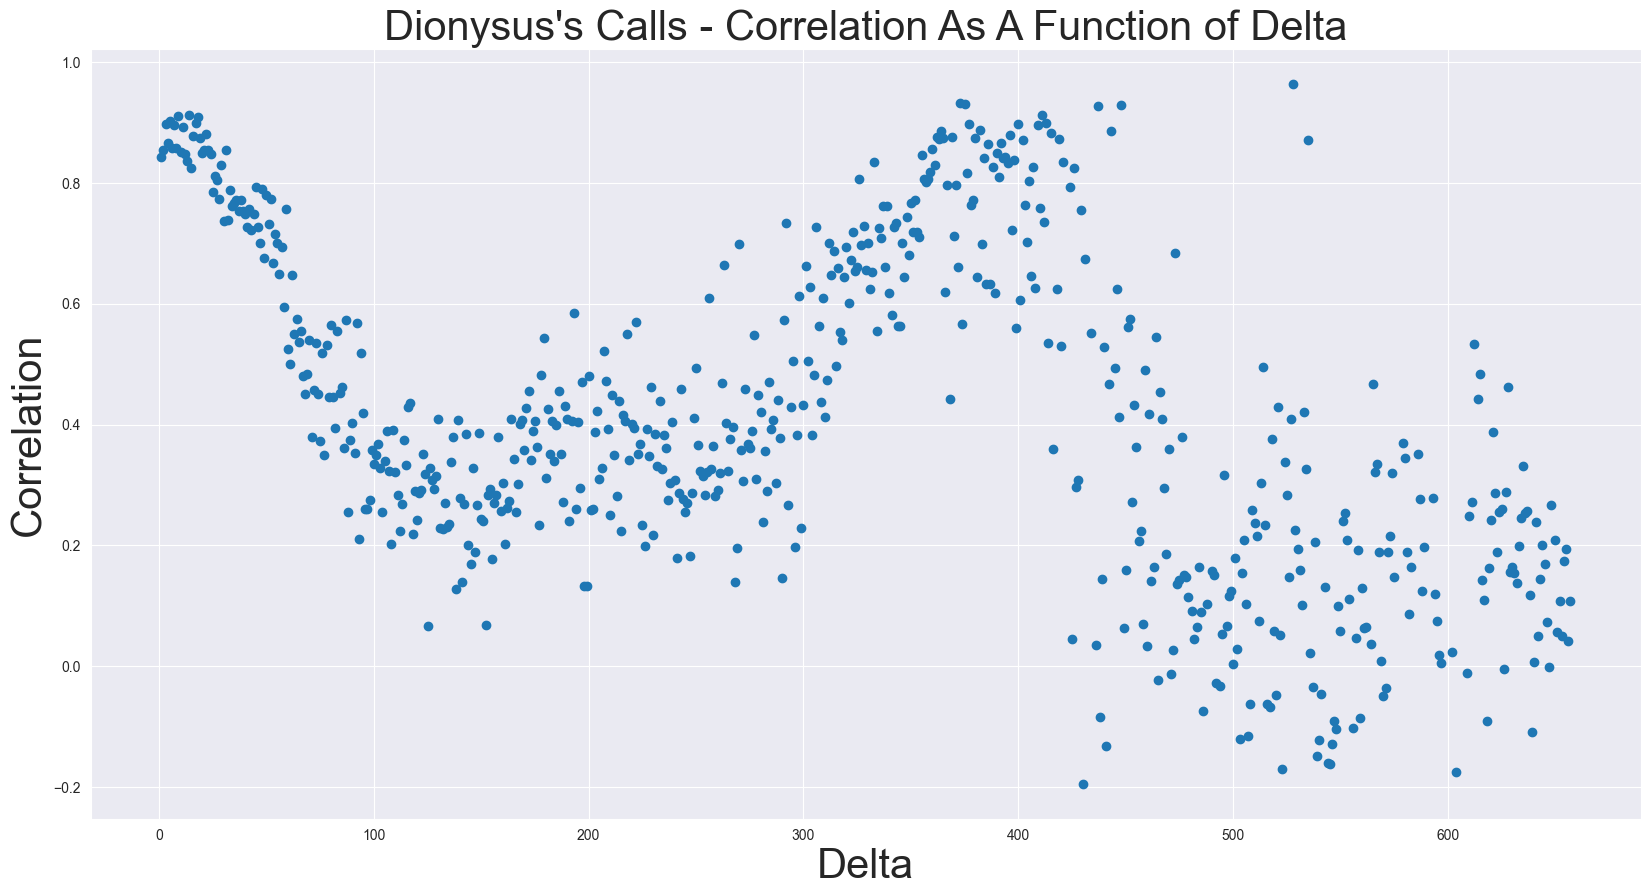

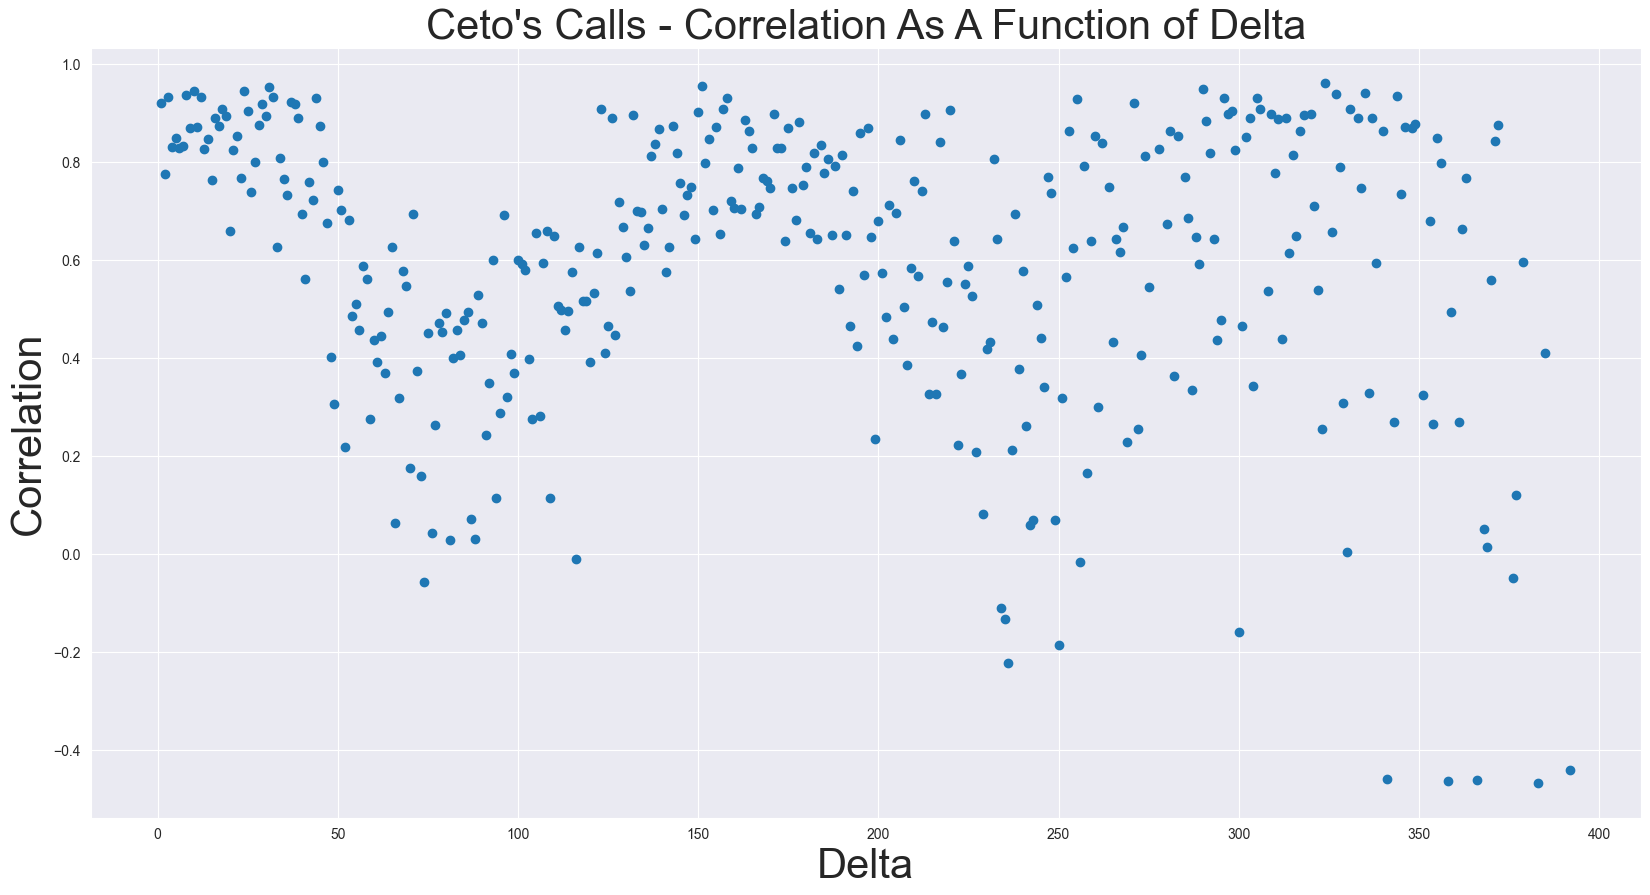

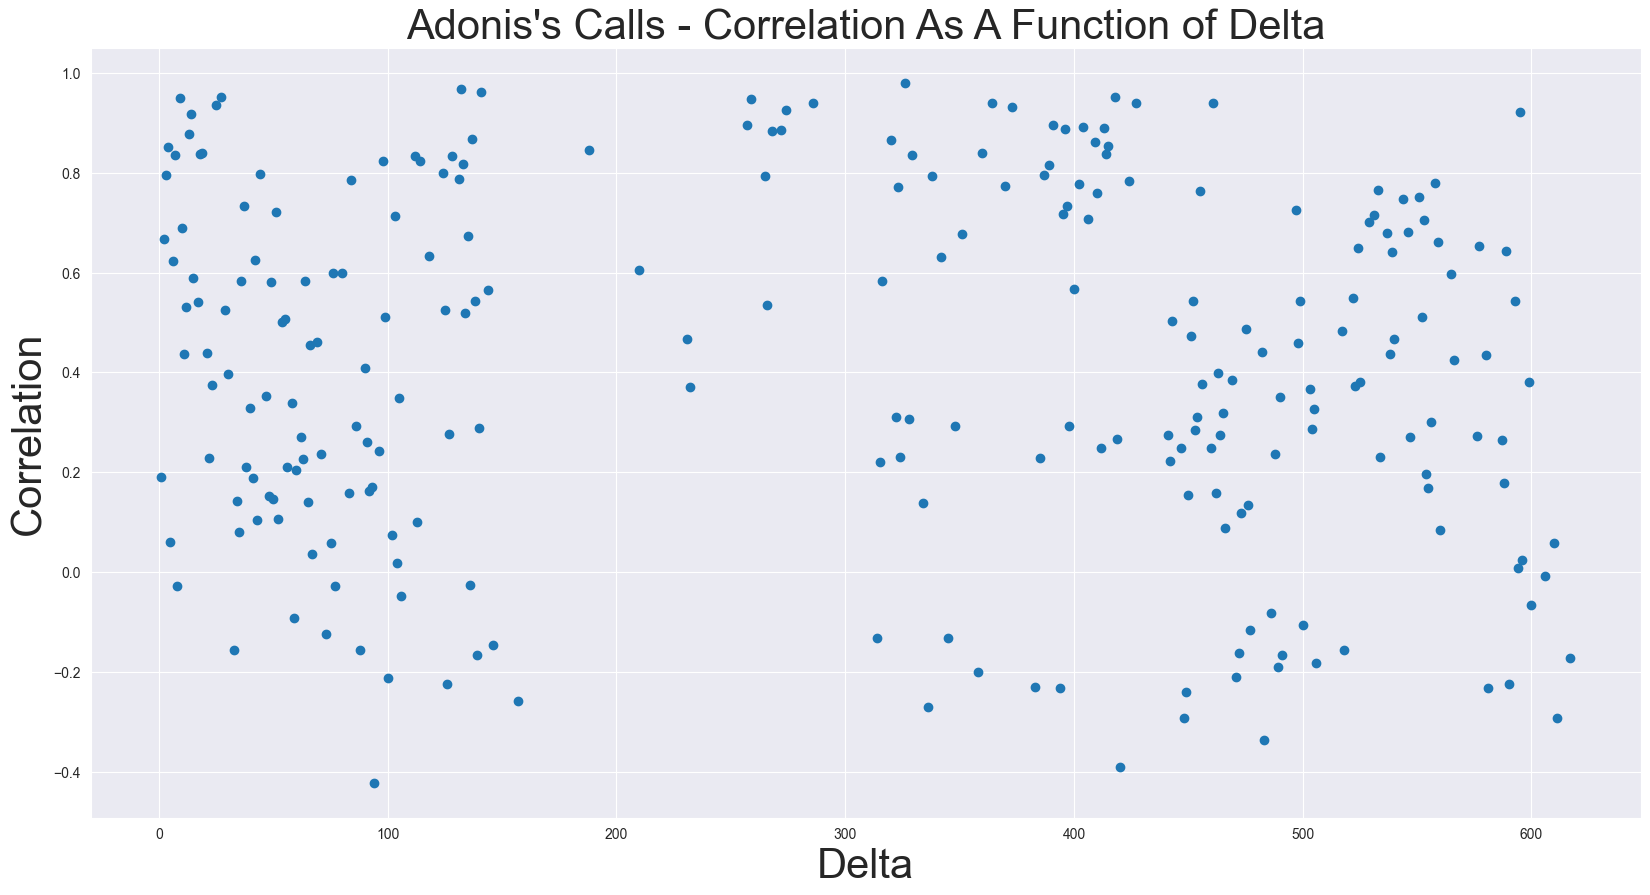

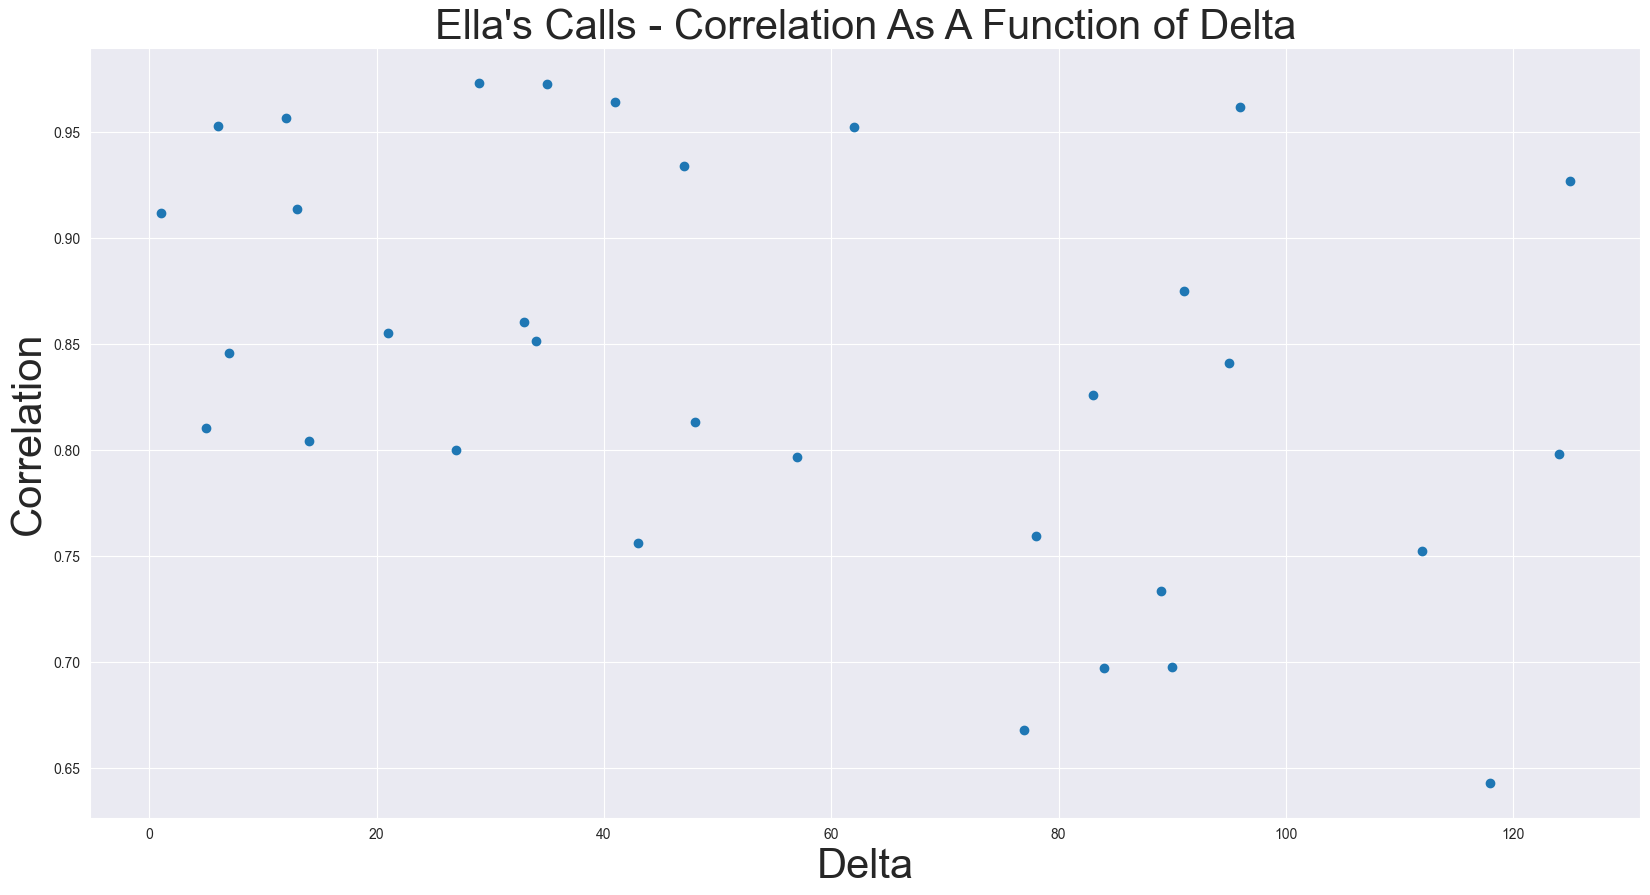

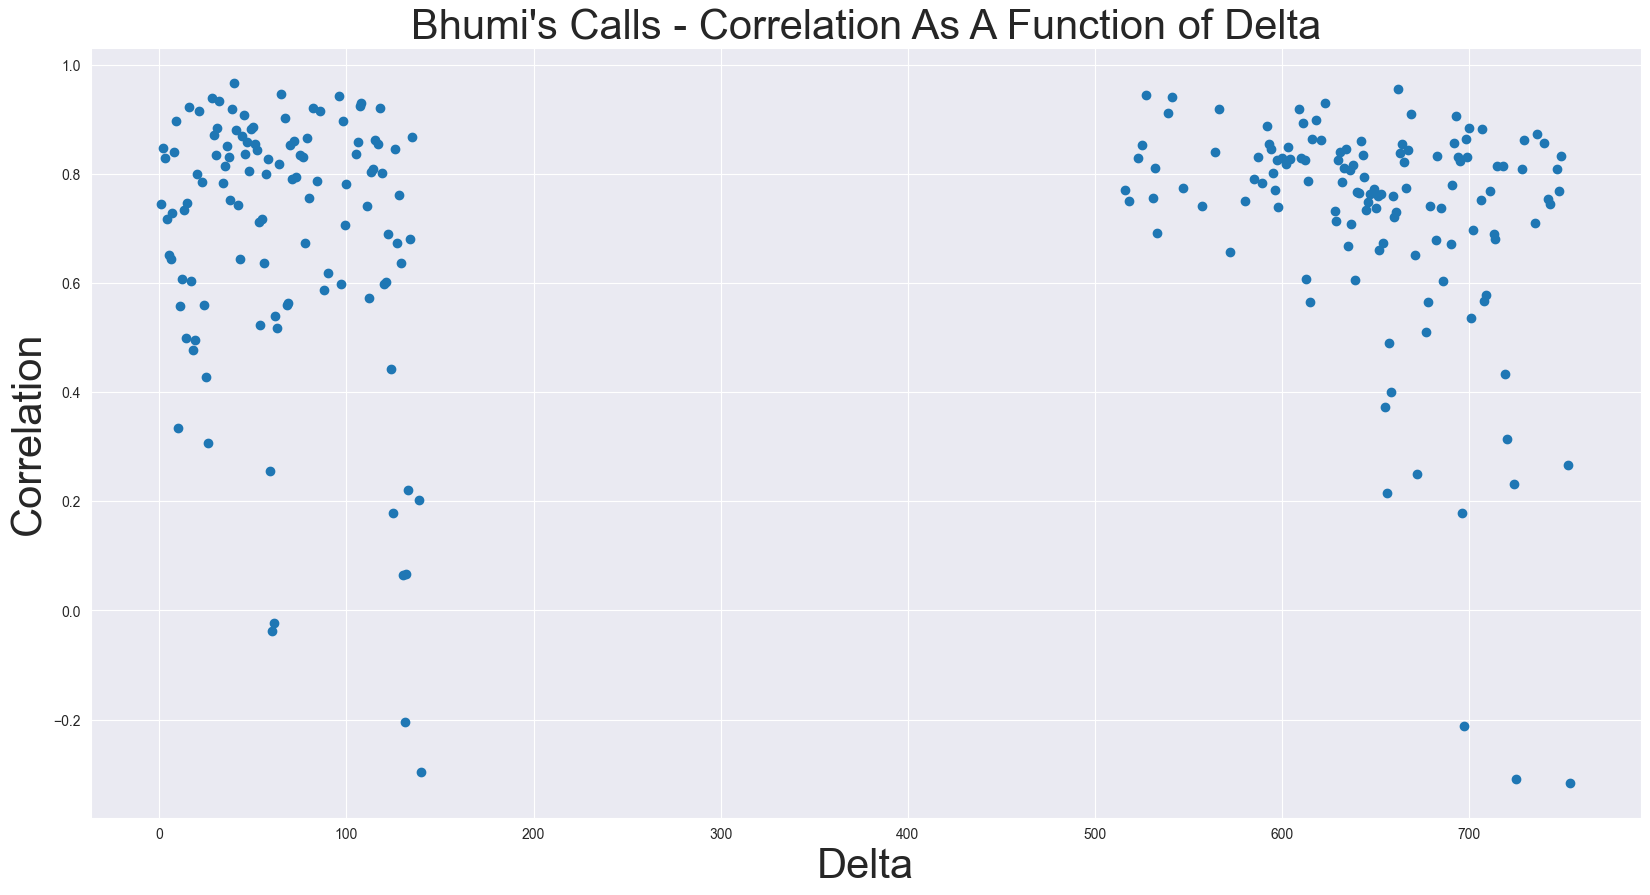

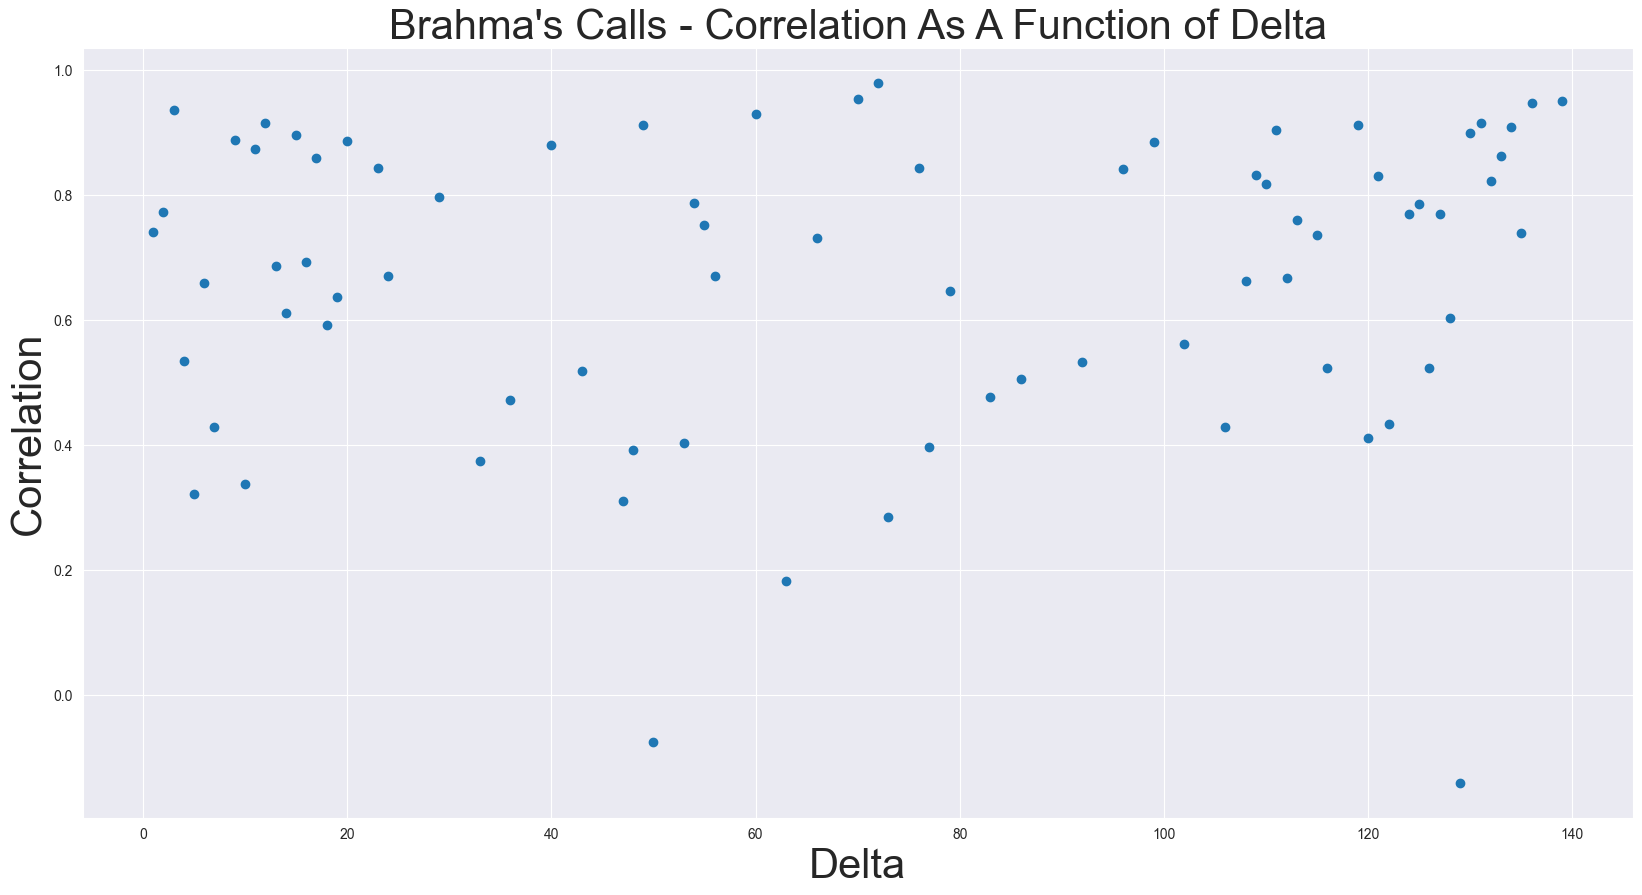

In [40]:
for caller in df["caller"].unique():
    show_average_corr_per_day_delta_for_every_caller_2(df,caller)